In [1]:
# Imports
from clef.code import *
import statistics
# Imports
import datetime
import sys
import os
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import xarray as xr
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import xesmf as xe

In [2]:
def variable_lat_weighed(variable):
    """
    Compute lat variable from lat,lon and maybe time data
    """
    # Weighing Data
    weights = np.cos(np.deg2rad(variable.lat))
    weights.name = "weights"

    variable_weighed = variable.weighted(weights) # latitude weighted
    

    variable_weighed_mean = variable_weighed.mean(("lon", "lat")) # average surface air temperature weighed (over time)
    
    return variable_weighed_mean

In [3]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
def slice_and_merge_full_run(ds_1pctCO2, ds_ZEC):
    """Goal is to slice 1pctCO2 run at the branching point, and merge the sliced data with the branching
    phase of the full zecmip experiment.
    
    Arguments:
    
    ds_1pctCO2 (data array): time, lat, lon 1pctCO2 data array
    ds_ZEC (data array): time, lat, lon ZEC phase data array
    time_1pctCO2_branch (time): time associated with branching point 1pctCO2 -> ZEC phase
    
    
    Return:
    
    
    """
    # Slicing the 1pctCO2 data array
    
    date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch = find_date_branch(ds_ZEC, ds_1pctCO2)
    
    # getting year of branch -- this is assuming a years resample for plotting
    year_branch = round(time_1pctCO2_branch_index/12)
    
    ds_1pctCO2_sliced = ds_1pctCO2.sel(time=slice(ds_1pctCO2.time[0], time_1pctCO2_branch))
    
    #Concatenate with the ZEC phase of the experiment
    ds_sliced_concatenated = xr.concat([ds_1pctCO2_sliced, ds_ZEC], dim="time")
        
    return ds_sliced_concatenated, year_branch


def find_date_branch(ds_ZEC, ds_1pctCO2):
    """Goal is to find the date and index of date of branch in the 1pctCO2 run
    
    Arguments:
    
    ds_ZEC (data array): ZEC phase data array for ZECMIP run
    ds_1pctCO2 (data array): 1pctCO2 phase data array for ZECMIP run
    
    Returns:
    
    time_1pctCO2_branch_index (int): Index for the exact month+year of branching point
    date_initial_ZEC (date): first date from the ZEC phase of the experiment
    time_1pctCO2_branch (date): Date of branch (should match EXACT date_initial_ZEC)
    
    """
    
    # Figure out the first date of the ZEC branch
    date_initial_ZEC = ds_ZEC.time[0]
    
    for i in range(len(ds_1pctCO2.time)):
        
        # Pick time value
        time_1pctCO2 = ds_1pctCO2.time[i]
        
        # Checking if time in 1pctCO2 is same as initial ZEC
        if time_1pctCO2 == date_initial_ZEC:
            
            # if the dates are equal on branch and 1pctCO2, this is the branching date
            time_1pctCO2_branch_index = i
            
            # assign time
            time_1pctCO2_branch=ds_1pctCO2.time[i]
        
    return date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch

# Land data

In [5]:
land_MOHC = xr.open_mfdataset("/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/v20190705/*.nc",
                              combine='nested',concat_dim='time')

land_ACCESS_ESM15 = xr.open_mfdataset("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/sftlf/gn/latest/*.nc",
                              combine='nested',concat_dim='time')

land_MIROC = xr.open_mfdataset("/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/fx/sftlf/gn/v20190823/*.nc",
                              combine='nested',concat_dim='time')

land_mask_concat = [land_MIROC, land_MOHC, land_ACCESS_ESM15]

In [6]:
model_names = ["MIROC-ES2L", "UKESM1-0-LL",
              "ACCESS-ESM1.5"]

member_str_names = ["MIROC-ES2L", "UKESM1-0-LL",
              "ACCESS-ESM1.5"]

branching_exp_str = ["750PgC", "1000PgC", "2000PgC"]

In [7]:
early_int = 25
late_int = 84
years_window_baseline=30
n_years_window_ZEC = 30

# ZEC monthly mean calculations

In [8]:
def ZEC_baseline_climatology_bounds(time_1pctCO2_branch_index, ds_1pctCO2, years_window_baseline):
    """Goal is to use the branching index recovered from find_date_branch() (time_1pctCO2_branch_index)
    to find the exact year+month for upper and lower bound of the ZEC baseline climatology
    
    THIS IS MEANT FOR MONTHLY DATA
    
    Arguments:
    
    time_1pctCO2_branch_index (int): Index for the exact month+year of branching point
    ds_1pctCO2 (data array): 1pctCO2 phase data array for ZECMIP run
    years_window (integer EVEN): number of years included in the window centered on branch point (20Y examp from MacDougall)
    
    Returns:
    
    index_upper_1pctCO2_clim (int): index associated with upper bound of 20Y baseline climatology from 1pctCO2
    index_lower_1pctCO2_clim (int): index associated with lower bound of 20Y baseline climatology from 1pctCO2
    time_upper_1pctCO2_clim (time): time associated with upper bound of 20Y baseline climatology from 1pctCO2
    time_lower_1pctCO2_clim (time): time associated with lower bound of 20Y baseline climatology from 1pctCO2
    """
    
    # number of indices to shift centered from the branching index
    index_shift_upper = ((years_window_baseline)*12)/2 # (Years total * 12 months)/2 ---> Symmetric about
    index_shift_lower = ((years_window_baseline)*12)/2
    
    # Upper and lower indices 
    index_upper_1pctCO2_clim=int(time_1pctCO2_branch_index+index_shift_upper) # shifting up
    index_lower_1pctCO2_clim=int(time_1pctCO2_branch_index-index_shift_lower) # shifting back
    
    # find lower and upper times of 20Y baseline climatology
    time_lower_1pctCO2_clim = ds_1pctCO2.time[index_lower_1pctCO2_clim]
    time_upper_1pctCO2_clim = ds_1pctCO2.time[index_upper_1pctCO2_clim]
    
    return index_upper_1pctCO2_clim, index_lower_1pctCO2_clim, time_lower_1pctCO2_clim, time_upper_1pctCO2_clim
    

In [9]:
def baseline_climatolgy(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim, ds_1pctCO2):
    """Goal is to compute the baseline climatology based on the lower and upper bound indices
    recovered usigng ZEC_baseline_climatology_bounds()
    
    Arguments:
    
    time_upper_1pctCO2_clim (time): time associated with upper bound of 20Y baseline climatology from 1pctCO2
    time_lower_1pctCO2_clim (time): time associated with lower bound of 20Y baseline climatology from 1pctCO2
    ds_1pctCO2
    
    Returns:
    baseline_clim_lat_lon (lat, lon): array of global temperatures for the baseline climatology
    baseline_clim_tas (float): the GMST of the baseline climatolgy
    
    """
    
    # slicing the 1pctCO2 run by the upper and lower bounds of the branching time
    baseline_clim_time_lat_lon = ds_1pctCO2.sel(time=slice(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim))
    
    # taking time mean of sliced data for a single climatology (lat, lon)
    baseline_clim_lat_lon = ds_1pctCO2.sel(time=slice(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim)).mean(dim='time')
    
    return baseline_clim_lat_lon, baseline_clim_time_lat_lon
    

In [10]:
def ZEC_calculations_M_early_late_updt(ds_ZEC, n_years_window_ZEC, early_int, late_int):
    """
    Goal is to calculate climatology for an early period and late period
    in zero emissions phase of experiment. 
    
    Arguments:
    
    ds_ZEC (time, lat, lon): Raw or regridded monthly resampled  data for ZEC phase of specific model
    n_years_window (int): Number of years TOTAL centered on ZEC. Example 20 would give 10Y on each side of ZEC#
    early_int (int): year to center around for "early" ZEC climatology. i.e value of 40 would be climate from
                    years 30-49 for a 20 year window
                    
    early_int (int): year to center around for "late" ZEC climatology. i.e value of 80 would be climate from
                    years 70-89 for a 20 year window
    
    GMST_baseline (float): Global mean surface temperature of the 20Y window of 1pct CO2 run from
    baseline_1pctCO2_indices_MON
    
    model_name (str): Indicator for which model is being analyzed
    
    
    Returns:x
    
    ZEC_i (float): ZEC_i value
    ZEC_i_climatology (lat, lon): latitude longitude data for 20Y average about ZEC_i (10Y either side)
    ZEC_25_climatology_normalized
    
    """
    
    # for early climatology
    ZEC_early_lower_index = int((early_int*12)-(n_years_window_ZEC*12)/2) # index for lower limit of early climatolgy
    ZEC_early_upper_index = int((early_int*12)+((n_years_window_ZEC-2)*12)/2) # index for upper limit of early climatolgy
    ZEC_early_lower_time = ds_ZEC.time[ZEC_early_lower_index] # time value of lower limit of early clim
    ZEC_early_upper_time = ds_ZEC.time[ZEC_early_upper_index] # time value of lower limit of early clim
    ZEC_early_climatology = ds_ZEC.sel(time=slice(ZEC_early_lower_time, ZEC_early_upper_time)).mean(dim='time')
    ZEC_early_climatology_mon = ds_ZEC.sel(time=slice(ZEC_early_lower_time, ZEC_early_upper_time)) #includes time coordinate

    

    ZEC_late_lower_index = int((late_int*12)-(n_years_window_ZEC*12)/2) # index for lower limit of late climatolgy
    ZEC_late_upper_index = int((late_int*12)+((n_years_window_ZEC-2)*12)/2) # index for upper limit of late climatolgy
    ZEC_late_lower_time = ds_ZEC.time[ZEC_late_lower_index] # time value of lower limit of late clim
    ZEC_late_upper_time = ds_ZEC.time[ZEC_late_upper_index] # time value of lower limit of late clim
    ZEC_late_climatology = ds_ZEC.sel(time=slice(ZEC_late_lower_time, ZEC_late_upper_time)).mean(dim='time')
    ZEC_late_climatology_mon = ds_ZEC.sel(time=slice(ZEC_late_lower_time, ZEC_late_upper_time)) # includes time coordinate
    
    return [ZEC_early_climatology, ZEC_early_climatology_mon, 
            ZEC_late_climatology, ZEC_late_climatology_mon]
    


def ZEC_full_calculation_early_late(ds_ZEC, ds_1pctCO2, years_window_baseline, n_years_window_ZEC, early_int, late_int):
    """Goal is to calculate ZEC25 ZEC50 and ZEC90 values completely using the 1pctCO2 and ZEC phase data arrays.
    Note: This will call on previously written functions 
    
    Arguments:
    
    ds_ZEC (data array): ZEC phase data array MONTHLY
    ds_1pctCO2 (data array): 1pctCO2 phase data array MONTHLY
    model_name (str): string of model name
    years_window_baseline (integer EVEN): number of years included in the window centered on branch point (20Y examp from MacDougall)
    n_years_window_ZEC (int): Number of years TOTAL centered on ZEC. Example 20 would give 10Y on each side of ZEC#
    
    
    Returns:
    
    ZEC values and climatologies, plus the time and index associated with branching (relative to 1pctCO2
    The time and index will be used to slice up the datasets)

    """
    # first, finding intial time of the ZEC branch, and locating the index for branching point from 1pctCO2
    date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch = find_date_branch(ds_ZEC, ds_1pctCO2)
    
    # Next, get times and indices associated with the baseline climatology period: watch out for 
    index_upper_1pctCO2_clim, index_lower_1pctCO2_clim, time_lower_1pctCO2_clim, time_upper_1pctCO2_clim = ZEC_baseline_climatology_bounds(time_1pctCO2_branch_index, ds_1pctCO2, years_window_baseline)

    # Next compute the baseline climatology and GMST of the baseline climatology
    baseline_clim_lat_lon, baseline_clim_time_lat_lon = baseline_climatolgy(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim, ds_1pctCO2)
    
    # Next compute the ZEC25, ZEC50, ZEC90 values and climatologies
    [ZEC_early_value, ZEC_early_climatology, ZEC50_value, 
     ZEC50_climatology, ZEC_late_value, ZEC_late_climatology, 
     ZEC_early_climatology_mon, ZEC_50_climatology_mon, ZEC_late_climatology_mon] = ZEC_calculations_M_early_late(ds_ZEC, n_years_window_ZEC, early_int, late_int)
    
    
    ZEC_year_lat_lon_full = ds_ZEC.resample(time='Y').mean(dim='time')-baseline_clim_lat_lon
    
    return [ZEC_early_climatology_mon,
            ZEC_late_climatology_mon, 
            baseline_clim_time_lat_lon]

In [11]:
def tas_weighed(tas):
    """Compute lat weighed annual temperature progression
    
    Inputs:
    tas: temperature array from dataset (time,lat,lon)
    
    Outputs:
    tas_weighed_mean: 1D Temp array (time)
    
    """
    # Weighing Data
    weights = np.cos(np.deg2rad(tas.lat))
    weights.name = "weights"

    tas_weighed = tas.weighted(weights) # latitude weighted temperature array
    

    tas_weighed_mean = tas_weighed.mean(("lon", "lat")) # average surface air temperature weighed (over time)
    
    return tas_weighed_mean

# Tas

In [12]:
tas_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

tas_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190406/*.nc',
                                     combine='nested',concat_dim='time')

tas_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')



# 1000
tas_1000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210/*.nc',
                                     combine='nested',concat_dim='time')

tas_1000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

tas_1000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 2000
tas_2000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/tas/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

tas_2000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

tas_2000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-2000PgC/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 750
tas_750_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-750PgC/r1i1p1f2/Amon/tas/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

tas_750_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-750PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

tas_750_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-750PgC/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


In [13]:
tas_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

tas_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

tas_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

# Error with MIROC piControl inconsistent time dtypes. Slicing to 100 years of consisitent time unit
tas_piControl_MIROC_ed = tas_piControl_MIROC.isel(time=slice(400*12, 500*12))

In [14]:
concat_tas_750 = [tas_750_MIROC, tas_750_MOHC, tas_750_ACCESS]
concat_tas_1000 = [tas_1000_MIROC, tas_1000_MOHC, tas_1000_ACCESS]
concat_tas_2000 = [tas_2000_MIROC, tas_2000_MOHC, tas_2000_ACCESS]

concat_tas_1pctCO2 = [tas_1pctCO2_MIROC, tas_1pctCO2_MOHC, tas_1pctCO2_ACCESS]

concat_tas_piControl = [tas_piControl_MIROC_ed, tas_piControl_MOHC, tas_piControl_ACCESS]

In [15]:
def tas_mon_climate_slices(concat_tas_750, concat_tas_1000, concat_tas_2000,
                          conat_tas_1pctCO2):

    "slice the nz baseline and year 85 tas data"

    concat_tas_warming_750 = []
    concat_tas_warming_1000 = []
    concat_tas_warming_2000 = []

    concat_tas_NZ_750 = []
    concat_tas_NZ_1000 = []
    concat_tas_NZ_2000 = []

    model_name="blank"
    
    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_tas_750)):
        # going by model

        ds_ZEC = concat_tas_750[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon,
         ZEC_late_climatology_mon, 
         baseline_clim_time_lat_lon] = ZEC_full_calculation_early_late(ds_ZEC, 
                                                                       ds_1pctCO2, 
                                                                       years_window_baseline, 
                                                                       n_years_window_ZEC, 
                                                                       early_int, late_int)

        # appending results
        concat_tas_warming_750.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_750.append(ZEC_late_climatology_mon)


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_tas_1000)):
        # going by model

        ds_ZEC = concat_tas_1000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon,
         ZEC_late_climatology_mon, 
         baseline_clim_time_lat_lon] = ZEC_full_calculation_early_late(ds_ZEC, 
                                                                       ds_1pctCO2, 
                                                                       years_window_baseline, 
                                                                       n_years_window_ZEC, 
                                                                       early_int, late_int)

        # appending results
        concat_tas_warming_1000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_1000.append(ZEC_late_climatology_mon)


    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_tas_2000)):
        # going by model

        ds_ZEC = concat_tas_2000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon,
         ZEC_late_climatology_mon, 
         baseline_clim_time_lat_lon] = ZEC_full_calculation_early_late(ds_ZEC, 
                                                                       ds_1pctCO2, 
                                                                       years_window_baseline, 
                                                                       n_years_window_ZEC, 
                                                                       early_int, late_int)

        # appending results
        concat_tas_warming_2000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_2000.append(ZEC_late_climatology_mon)

    return [concat_tas_warming_750, concat_tas_NZ_750,
           concat_tas_warming_1000, concat_tas_NZ_1000,
           concat_tas_warming_2000, concat_tas_NZ_2000]
        

    

In [16]:
def tas_mon_climate_slices_w_anom(concat_tas_750, concat_tas_1000, concat_tas_2000,
                          conat_tas_1pctCO2, concat_tas_piControl):

    "slice the nz baseline and year 85 tas data"

    # raw
    concat_tas_warming_750 = []
    concat_tas_warming_1000 = []
    concat_tas_warming_2000 = []

    concat_tas_NZ_750 = []
    concat_tas_NZ_1000 = []
    concat_tas_NZ_2000 = []

    # anoms
    concat_tas_warming_750_anom = []
    concat_tas_warming_1000_anom = []
    concat_tas_warming_2000_anom = []

    concat_tas_NZ_750_anom = []
    concat_tas_NZ_1000_anom = []
    concat_tas_NZ_2000_anom = []

    model_name="blank"

    # concat picontrol tas lat lon annual
    concat_tas_piControl_annual_lat_lon = []

    for model in range(len(concat_tas_piControl)):

        # average annual mean full piControl
        tas_lat_lon = concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_tas_piControl_annual_lat_lon.append(tas_lat_lon)

    
    
    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_tas_750)):
        # going by model

        ds_ZEC = concat_tas_750[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon,
         ZEC_late_climatology_mon, 
         baseline_clim_time_lat_lon] = ZEC_full_calculation_early_late(ds_ZEC, 
                                                                       ds_1pctCO2, 
                                                                       years_window_baseline, 
                                                                       n_years_window_ZEC, 
                                                                       early_int, late_int)

        # appending results
        concat_tas_warming_750.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_750_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_750_anom.append(tas_anomaly_lat_lon_NZ)
        


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_tas_1000)):
        # going by model

        ds_ZEC = concat_tas_1000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon,
         ZEC_late_climatology_mon, 
         baseline_clim_time_lat_lon] = ZEC_full_calculation_early_late(ds_ZEC, 
                                                                       ds_1pctCO2, 
                                                                       years_window_baseline, 
                                                                       n_years_window_ZEC, 
                                                                       early_int, late_int)


        
    
        
        # appending results
        concat_tas_warming_1000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_1000_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_1000_anom.append(tas_anomaly_lat_lon_NZ)


    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_tas_2000)):
        # going by model

        ds_ZEC = concat_tas_2000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon,
         ZEC_late_climatology_mon, 
         baseline_clim_time_lat_lon] = ZEC_full_calculation_early_late(ds_ZEC, 
                                                                       ds_1pctCO2, 
                                                                       years_window_baseline, 
                                                                       n_years_window_ZEC, 
                                                                       early_int, late_int)

        # appending results
        concat_tas_warming_2000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_2000_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_2000_anom.append(tas_anomaly_lat_lon_NZ)

    

    return [concat_tas_warming_750, concat_tas_NZ_750,
           concat_tas_warming_1000, concat_tas_NZ_1000,
           concat_tas_warming_2000, concat_tas_NZ_2000,
           
           
           concat_tas_warming_750_anom, concat_tas_NZ_750_anom,
           concat_tas_warming_1000_anom, concat_tas_NZ_1000_anom,
           concat_tas_warming_2000_anom, concat_tas_NZ_2000_anom]
        

# New ZEC calcs

In [17]:
def ZEC_climate_slices_monthly(ds_ZEC_branch, ds_1pctCO2, 
                               years_window_baseline, n_years_window_ZEC, 
                               early_int, late_int):

    """
    da_ZEC_branch - data array of ZEC branch data for single branch (1000, 750)
    da_1pctCO2_branch - data array of 1pctCO2 data 
    years_window_baseline - int 30 probably
    n_years_window_ZEC - int 30 probably
    early_int - integer year of first post ZEC climate slice - center say y25
    late_int - integer year of second post ZEC climate slice - center say 85


    """

    # first, finding intial time of the ZEC branch, and locating the index for branching point from 1pctCO2
    [date_initial_ZEC, time_1pctCO2_branch_index, 
     time_1pctCO2_branch] = find_date_branch(ds_ZEC_branch, ds_1pctCO2)

    # Next, get times and indices associated with the baseline climatology period: watch out for 
    [index_upper_1pctCO2_clim, index_lower_1pctCO2_clim, 
    time_lower_1pctCO2_clim, time_upper_1pctCO2_clim] = ZEC_baseline_climatology_bounds(time_1pctCO2_branch_index,
                                                                                        ds_1pctCO2, years_window_baseline)

    # Next compute the baseline climatology and GMST of the baseline climatology
    baseline_clim_lat_lon, baseline_clim_time_lat_lon = baseline_climatolgy(time_lower_1pctCO2_clim, 
                                                                            time_upper_1pctCO2_clim, 
                                                                            ds_1pctCO2)
    
    
    # Next compute the ZEC25, ZEC50, ZEC90 values and climatologies
    [ZEC_early_climatology, ZEC_early_climatology_mon,
     ZEC_late_climatology, ZEC_late_climatology_mon] = ZEC_calculations_M_early_late_updt(ds_ZEC_branch, n_years_window_ZEC, early_int, late_int)

    
    
    return [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]
    

In [18]:
def tas_mon_climate_slices_w_anom_updt(concat_tas_750, concat_tas_1000, concat_tas_2000,
                          conat_tas_1pctCO2, concat_tas_piControl):

    "slice the nz baseline and year 85 tas data"

    # raw
    concat_tas_warming_750 = []
    concat_tas_warming_1000 = []
    concat_tas_warming_2000 = []

    concat_tas_NZ_750 = []
    concat_tas_NZ_1000 = []
    concat_tas_NZ_2000 = []

    # anoms
    concat_tas_warming_750_anom = []
    concat_tas_warming_1000_anom = []
    concat_tas_warming_2000_anom = []

    concat_tas_NZ_750_anom = []
    concat_tas_NZ_1000_anom = []
    concat_tas_NZ_2000_anom = []

    model_name="blank"

    # concat picontrol tas lat lon annual
    concat_tas_piControl_annual_lat_lon = []

    for model in range(len(concat_tas_piControl)):

        # average annual mean full piControl
        tas_lat_lon = concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_tas_piControl_annual_lat_lon.append(tas_lat_lon)

    
    
    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_tas_750)):
        # going by model

        ds_ZEC = concat_tas_750[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon] = ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_tas_warming_750.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_750_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_750_anom.append(tas_anomaly_lat_lon_NZ)
        


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_tas_1000)):
        # going by model

        ds_ZEC = concat_tas_1000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon] = ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        
        # appending results
        concat_tas_warming_1000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_1000_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_1000_anom.append(tas_anomaly_lat_lon_NZ)


    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_tas_2000)):
        # going by model

        ds_ZEC = concat_tas_2000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_tas_warming_2000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_2000_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_2000_anom.append(tas_anomaly_lat_lon_NZ)

    

    return [concat_tas_warming_750, concat_tas_NZ_750,
           concat_tas_warming_1000, concat_tas_NZ_1000,
           concat_tas_warming_2000, concat_tas_NZ_2000,
           
           
           concat_tas_warming_750_anom, concat_tas_NZ_750_anom,
           concat_tas_warming_1000_anom, concat_tas_NZ_1000_anom,
           concat_tas_warming_2000_anom, concat_tas_NZ_2000_anom]
        

In [19]:
[concat_tas_warming_750, concat_tas_NZ_750,
           concat_tas_warming_1000, concat_tas_NZ_1000,
           concat_tas_warming_2000, concat_tas_NZ_2000,
           
           
           concat_tas_warming_750_anom, concat_tas_NZ_750_anom,
           concat_tas_warming_1000_anom, concat_tas_NZ_1000_anom,
           concat_tas_warming_2000_anom, concat_tas_NZ_2000_anom]=tas_mon_climate_slices_w_anom_updt(concat_tas_750, concat_tas_1000, concat_tas_2000,
                          concat_tas_1pctCO2, concat_tas_piControl)

750 PgC calcs
1000 PgC calcs
2000 PgC calcs


In [20]:
def branch_tas_grid_plot_annual_warm_NZ_anoms(concat_tas_warming_branch_anom_latlon, concat_tas_NZ_branch_anom_latlon,
                        land_mask_concat, member_str_names, branching_exp_str):

    """

    plotting annual grid plots for temperature anomaly during warming, NZ, and difference
    
    """

    nrows = 3 # ensemble members
    ncols = 3 # warming anom, NZ anom, NZ-warming anom
    

    # mins and maxes during warming climate
    tas_anom_warming_min =0
    tas_anom_warming_max = 3
    
    tas_NZ_minus_warming_min = -2
    tas_NZ_minus_warming_max = 2

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(10,6))

    tas_cmap = "OrRd"
    tas_cmap_diff = "bwr"


    tas_NZ_minus_warming_annual_branch = []
    tas_NZ_minus_warming_JJA_branch = []
    tas_NZ_minus_warming_DJF_branch = []
    

    for member in range(len(concat_tas_warming_branch_anom_latlon)):
        
        print("Warming phase plotting ANNUAL")

        tas_warming_anom = concat_tas_warming_branch_anom_latlon[member]
        
        tas_warming_anom=tas_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        A = tas_warming_anom.tas.plot(ax=axes[member,0],transform=ccrs.PlateCarree(),
                                          vmin=tas_anom_warming_min, vmax=tas_anom_warming_max,
                                       cmap=tas_cmap, add_colorbar=False)
        
        axes[member,0].coastlines()
        axes[member,0].gridlines()
        axes[member,0].set_title(member_str_names[member]+ " " + branching_exp_str + "Warming", fontsize=10)



    for member in range(len(concat_tas_NZ_branch_anom_latlon)):
        
        print("NZ phase plotting ANNUAL")

        tas_NZ_anom = concat_tas_NZ_branch_anom_latlon[member]
        
        tas_NZ_anom=tas_NZ_anom.where(land_mask_concat[member].sftlf==100)
        
        A = tas_NZ_anom.tas.plot(ax=axes[member,1],transform=ccrs.PlateCarree(),
                                          vmin=tas_anom_warming_min, vmax=tas_anom_warming_max,
                                       cmap=tas_cmap, add_colorbar=False)
        
        axes[member,1].coastlines()
        axes[member,1].gridlines()
        axes[member,1].set_title(member_str_names[member]+ " " + branching_exp_str + "NZ", fontsize=10)


    for member in range(len(concat_tas_NZ_branch_anom_latlon)):
        
        print("NZ-warming phase plotting ANNUAL, NZ anom")

        tas_NZ_minus_warming_anom = concat_tas_NZ_branch_anom_latlon[member]-concat_tas_warming_branch_anom_latlon[member]
        
        tas_NZ_minus_warming_anom=tas_NZ_minus_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        B = tas_NZ_minus_warming_anom.tas.plot(ax=axes[member,2],transform=ccrs.PlateCarree(),
                                          vmin=tas_NZ_minus_warming_min, vmax=tas_NZ_minus_warming_max,
                                       cmap=tas_cmap_diff, add_colorbar=False)
        
        axes[member,2].coastlines()
        axes[member,2].gridlines()
        axes[member,2].set_title(member_str_names[member]+ " " + branching_exp_str + "NZ-warming", fontsize=10)



    plt.colorbar(A, ax=axes[2,:2], label="Temperature anomaly (C)", location='bottom',
            pad=0.05)

    plt.colorbar(B, ax=axes[2,2], label="Temperature anomaly (C)", location='bottom',
            pad=0.05)

# Pr analysis first

In [21]:
pr_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

pr_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/pr/gn/v20190406/*.nc',
                                     combine='nested',concat_dim='time')

pr_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/pr/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

In [22]:
# 1000
pr_1000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/pr/gn/v20200210/*.nc',
                                     combine='nested',concat_dim='time')

pr_1000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/pr/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

pr_1000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 2000
pr_2000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/pr/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

pr_2000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/pr/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

pr_2000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-2000PgC/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 750
pr_750_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-750PgC/r1i1p1f2/Amon/pr/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

pr_750_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-750PgC/r1i1p1f2/Amon/pr/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

pr_750_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-750PgC/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

In [23]:
pr_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/pr/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

pr_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/pr/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

pr_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

In [24]:
concat_pr_750 = [pr_750_MIROC, pr_750_MOHC, pr_750_ACCESS]
concat_pr_1000 = [pr_1000_MIROC, pr_1000_MOHC, pr_1000_ACCESS]
concat_pr_2000 = [pr_2000_MIROC, pr_2000_MOHC, pr_2000_ACCESS]

pr_piControl_MIROC_ed = pr_piControl_MIROC.isel(time=slice(400*12, 500*12))

concat_pr_1pctCO2 = [pr_1pctCO2_MIROC, pr_1pctCO2_MOHC, pr_1pctCO2_ACCESS]
concat_pr_piControl = [pr_piControl_MIROC_ed, pr_piControl_MOHC, pr_piControl_ACCESS]


In [25]:
def pr_mon_climate_slices_w_anom_updt(concat_pr_750, concat_pr_1000, concat_pr_2000,
                          conat_pr_1pctCO2, concat_pr_piControl):

    "slice the nz baseline and year 85 pr data"

    # raw
    concat_pr_warming_750 = []
    concat_pr_warming_1000 = []
    concat_pr_warming_2000 = []

    concat_pr_NZ_750 = []
    concat_pr_NZ_1000 = []
    concat_pr_NZ_2000 = []

    # anoms
    concat_pr_warming_750_anom = []
    concat_pr_warming_1000_anom = []
    concat_pr_warming_2000_anom = []

    concat_pr_NZ_750_anom = []
    concat_pr_NZ_1000_anom = []
    concat_pr_NZ_2000_anom = []

    model_name="blank"

    # concat picontrol pr lat lon annual
    concat_pr_piControl_annual_lat_lon = []

    for model in range(len(concat_pr_piControl)):

        # average annual mean full piControl
        pr_lat_lon = concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_pr_piControl_annual_lat_lon.append(pr_lat_lon)

    
    
    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_pr_750)):
        # going by model

        ds_ZEC = concat_pr_750[model]
        ds_1pctCO2 = conat_pr_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_pr_warming_750.append(baseline_clim_time_lat_lon)
        concat_pr_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs -- percentage for precip
        pr_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/(concat_pr_piControl_annual_lat_lon[model])
        pr_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]

        concat_pr_warming_750_anom.append(pr_anomaly_lat_lon_warming)
        concat_pr_NZ_750_anom.append(pr_anomaly_lat_lon_NZ)
        


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_pr_1000)):
        # going by model

        ds_ZEC = concat_pr_1000[model]
        ds_1pctCO2 = conat_pr_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        
        # appending results
        concat_pr_warming_1000.append(baseline_clim_time_lat_lon)
        concat_pr_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        pr_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]
        pr_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]

        concat_pr_warming_1000_anom.append(pr_anomaly_lat_lon_warming)
        concat_pr_NZ_1000_anom.append(pr_anomaly_lat_lon_NZ)


    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_pr_2000)):
        # going by model

        ds_ZEC = concat_pr_2000[model]
        ds_1pctCO2 = conat_pr_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_pr_warming_2000.append(baseline_clim_time_lat_lon)
        concat_pr_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        pr_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]
        pr_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]

        concat_pr_warming_2000_anom.append(pr_anomaly_lat_lon_warming)
        concat_pr_NZ_2000_anom.append(pr_anomaly_lat_lon_NZ)

    

    return [concat_pr_warming_750, concat_pr_NZ_750,
           concat_pr_warming_1000, concat_pr_NZ_1000,
           concat_pr_warming_2000, concat_pr_NZ_2000,
           
           
           concat_pr_warming_750_anom, concat_pr_NZ_750_anom,
           concat_pr_warming_1000_anom, concat_pr_NZ_1000_anom,
           concat_pr_warming_2000_anom, concat_pr_NZ_2000_anom]


In [26]:
[concat_pr_warming_750, concat_pr_NZ_750,
           concat_pr_warming_1000, concat_pr_NZ_1000,
           concat_pr_warming_2000, concat_pr_NZ_2000,
           
           
           concat_pr_warming_750_anom, concat_pr_NZ_750_anom,
           concat_pr_warming_1000_anom, concat_pr_NZ_1000_anom,
           concat_pr_warming_2000_anom, concat_pr_NZ_2000_anom]=pr_mon_climate_slices_w_anom_updt(concat_pr_750, concat_pr_1000, concat_pr_2000,
                          concat_pr_1pctCO2, concat_pr_piControl)


750 PgC calcs
1000 PgC calcs
2000 PgC calcs


In [27]:
def branch_pr_grid_plot_annual_warm_NZ_anoms(concat_pr_warming_branch_anom_latlon, concat_pr_NZ_branch_anom_latlon,
                        land_mask_concat, member_str_names, branching_exp_str):

    """

    plotting annual grid plots for temperature anomaly during warming, NZ, and difference
    
    """

    nrows = 3 # ensemble members
    ncols = 3 # warming anom, NZ anom, NZ-warming anom
    

    # mins and maxes during warming climate
    pr_anom_warming_min =-30
    pr_anom_warming_max = 30
    
    pr_NZ_minus_warming_min = -20
    pr_NZ_minus_warming_max = 20

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(10,6))

    pr_cmap = "BrBG"
    pr_cmap_diff = "BrBG"


    pr_NZ_minus_warming_annual_branch = []
    pr_NZ_minus_warming_JJA_branch = []
    pr_NZ_minus_warming_DJF_branch = []
    

    for member in range(len(concat_pr_warming_branch_anom_latlon)):
        
        print("Warming phase plotting ANNUAL")

        pr_warming_anom = concat_pr_warming_branch_anom_latlon[member]
        
        pr_warming_anom=pr_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        A = pr_warming_anom.pr.plot(ax=axes[member,0],transform=ccrs.PlateCarree(),
                                          vmin=pr_anom_warming_min, vmax=pr_anom_warming_max,
                                       cmap=pr_cmap, add_colorbar=False)
        
        axes[member,0].coastlines()
        axes[member,0].gridlines()
        axes[member,0].set_title(member_str_names[member]+ " " + branching_exp_str + "Warming", fontsize=10)



    for member in range(len(concat_pr_NZ_branch_anom_latlon)):
        
        print("NZ phase plotting ANNUAL")

        pr_NZ_anom = concat_pr_NZ_branch_anom_latlon[member]
        
        pr_NZ_anom=pr_NZ_anom.where(land_mask_concat[member].sftlf==100)
        
        A = pr_NZ_anom.pr.plot(ax=axes[member,1],transform=ccrs.PlateCarree(),
                                          vmin=pr_anom_warming_min, vmax=pr_anom_warming_max,
                                       cmap=pr_cmap, add_colorbar=False)
        
        axes[member,1].coastlines()
        axes[member,1].gridlines()
        axes[member,1].set_title(member_str_names[member]+ " " + branching_exp_str + "NZ", fontsize=10)


    for member in range(len(concat_pr_NZ_branch_anom_latlon)):
        
        print("NZ-warming phase plotting ANNUAL, NZ anom")

        pr_NZ_minus_warming_anom = concat_pr_NZ_branch_anom_latlon[member]-concat_pr_warming_branch_anom_latlon[member]
        
        pr_NZ_minus_warming_anom=pr_NZ_minus_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        B = pr_NZ_minus_warming_anom.pr.plot(ax=axes[member,2],transform=ccrs.PlateCarree(),
                                          vmin=pr_NZ_minus_warming_min, vmax=pr_NZ_minus_warming_max,
                                       cmap=pr_cmap_diff, add_colorbar=False)
        
        axes[member,2].coastlines()
        axes[member,2].gridlines()
        axes[member,2].set_title(member_str_names[member]+ " " + branching_exp_str + "NZ-warming", fontsize=10)

    plt.colorbar(A, ax=axes[2,:2], label="Precipitation Anomaly (%)", location='bottom',
            pad=0.05)

    plt.colorbar(B, ax=axes[2,2], label="Precipitation Anomaly (%)", location='bottom',
            pad=0.05)

    plt.savefig("/g/data/ob22/lc6551/SSP126_extended/ZECMIP_driv_figs/pr_annual_new_"+branching_exp_str+".png")



# Some pr-tas maps (Annual, DJA, JJF)


In [28]:
def plotting_pr_tas_correlation_annual_warming(concat_tas_warming_750, 
                                              concat_tas_warming_1000,
                                              concat_tas_warming_2000,
                                              
                                              concat_pr_warming_750, 
                                              concat_pr_warming_1000,
                                              concat_pr_warming_2000,
                                              
                                              concat_tas_piControl,
                                              concat_pr_piControl,
                                              model_names_str,
                                              branching_exp_str,
                                              land_mask_concat):


    """
    
    Plot grid of pr/tas anom grid cell mean for warming climate

    -Next - look into doing AR6 means because these could be super noisy

    """

    nrows = 3 # ensemble members
    ncols = 6 # warming anom, NZ anom, NZ-warming anom
    

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(12,8))

    pr_tas_cmap = "BrBG"
    pr_tas_cmap_warming_min = -20
    pr_tas_cmap_warming_max = 20

    pr_tas_cmap_NZ_min = -20
    pr_tas_cmap_NZ_max = 20


    # Looping through 750 and computing ratios
    
    print("750 calcs annual")
    for model in range(len(concat_tas_warming_750)):
        col_warming=0
        col_NZ_minus_warming=1
        
        print(model_names_str[model])
        branching_exp_string=branching_exp_str[0]

        # Warming calcs
        tas_lat_lon_anom_warming = concat_tas_warming_750[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_warming = 100*(concat_pr_warming_750[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        
        pr_tas_lat_lon_anom_ratio_warming = pr_lat_lon_anom_warming.pr/tas_lat_lon_anom_warming.tas
        pr_tas_lat_lon_anom_ratio_warming=pr_tas_lat_lon_anom_ratio_warming.where(land_mask_concat[model].sftlf==100)

        # NZ-warming calcs
        tas_lat_lon_anom_NZ = concat_tas_NZ_750[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_NZ = 100*(concat_pr_NZ_750[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_tas_lat_lon_anom_ratio_NZ = pr_lat_lon_anom_NZ.pr/tas_lat_lon_anom_NZ.tas
        
        # Anomaly full grid
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming = pr_tas_lat_lon_anom_ratio_NZ-pr_tas_lat_lon_anom_ratio_warming
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming=pr_tas_lat_lon_anom_ratio_NZ_minus_warming.where(land_mask_concat[model].sftlf==100)
        

        # Plotting
        A = pr_tas_lat_lon_anom_ratio_warming.plot(ax=axes[model,col_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_warming_min, vmax=pr_tas_cmap_warming_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_warming].coastlines()
        axes[model,col_warming].gridlines()
        axes[model,col_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "WC", fontsize=8)



        B = pr_tas_lat_lon_anom_ratio_NZ_minus_warming.plot(ax=axes[model,col_NZ_minus_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_NZ_min, vmax=pr_tas_cmap_NZ_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_NZ_minus_warming].coastlines()
        axes[model,col_NZ_minus_warming].gridlines()
        axes[model,col_NZ_minus_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "NZ-WC", fontsize=8)

    print("1000 calcs annual")
    for model in range(len(concat_tas_warming_1000)):
        col_warming=2
        col_NZ_minus_warming=3
        
        print(model_names_str[model])
        branching_exp_string=branching_exp_str[1]

        # Warming calcs
        tas_lat_lon_anom_warming = concat_tas_warming_1000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_warming = 100*(concat_pr_warming_1000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        
        pr_tas_lat_lon_anom_ratio_warming = pr_lat_lon_anom_warming.pr/tas_lat_lon_anom_warming.tas
        pr_tas_lat_lon_anom_ratio_warming=pr_tas_lat_lon_anom_ratio_warming.where(land_mask_concat[model].sftlf==100)

        # NZ-warming calcs
        tas_lat_lon_anom_NZ = concat_tas_NZ_1000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_NZ = 100*(concat_pr_NZ_1000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_tas_lat_lon_anom_ratio_NZ = pr_lat_lon_anom_NZ.pr/tas_lat_lon_anom_NZ.tas
        
        # Anomaly full grid
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming = pr_tas_lat_lon_anom_ratio_NZ-pr_tas_lat_lon_anom_ratio_warming
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming=pr_tas_lat_lon_anom_ratio_NZ_minus_warming.where(land_mask_concat[model].sftlf==100)
        

        # Plotting
        A = pr_tas_lat_lon_anom_ratio_warming.plot(ax=axes[model,col_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_warming_min, vmax=pr_tas_cmap_warming_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_warming].coastlines()
        axes[model,col_warming].gridlines()
        axes[model,col_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "WC", fontsize=8)



        B = pr_tas_lat_lon_anom_ratio_NZ_minus_warming.plot(ax=axes[model,col_NZ_minus_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_NZ_min, vmax=pr_tas_cmap_NZ_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_NZ_minus_warming].coastlines()
        axes[model,col_NZ_minus_warming].gridlines()
        axes[model,col_NZ_minus_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "NZ-WC", fontsize=8)

    print("2000 calcs annual")
    for model in range(len(concat_tas_warming_2000)):
        col_warming=4
        col_NZ_minus_warming=5
        
        print(model_names_str[model])
        branching_exp_string=branching_exp_str[2]

        # Warming calcs
        tas_lat_lon_anom_warming = concat_tas_warming_2000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_warming = 100*(concat_pr_warming_2000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        
        pr_tas_lat_lon_anom_ratio_warming = pr_lat_lon_anom_warming.pr/tas_lat_lon_anom_warming.tas
        pr_tas_lat_lon_anom_ratio_warming=pr_tas_lat_lon_anom_ratio_warming.where(land_mask_concat[model].sftlf==100)

        # NZ-warming calcs
        tas_lat_lon_anom_NZ = concat_tas_NZ_2000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_NZ = 100*(concat_pr_NZ_2000[model].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_tas_lat_lon_anom_ratio_NZ = pr_lat_lon_anom_NZ.pr/tas_lat_lon_anom_NZ.tas
        
        # Anomaly full grid
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming = pr_tas_lat_lon_anom_ratio_NZ-pr_tas_lat_lon_anom_ratio_warming
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming=pr_tas_lat_lon_anom_ratio_NZ_minus_warming.where(land_mask_concat[model].sftlf==100)
        

        # Plotting
        A = pr_tas_lat_lon_anom_ratio_warming.plot(ax=axes[model,col_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_warming_min, vmax=pr_tas_cmap_warming_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_warming].coastlines()
        axes[model,col_warming].gridlines()
        axes[model,col_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "WC", fontsize=8)



        B = pr_tas_lat_lon_anom_ratio_NZ_minus_warming.plot(ax=axes[model,col_NZ_minus_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_NZ_min, vmax=pr_tas_cmap_NZ_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_NZ_minus_warming].coastlines()
        axes[model,col_NZ_minus_warming].gridlines()
        axes[model,col_NZ_minus_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "NZ-WC", fontsize=8)
 

    return pr_tas_lat_lon_anom_ratio_warming, pr_tas_lat_lon_anom_ratio_NZ_minus_warming

In [29]:
member_str_names = ["MIROC-ES2L", "UKESM1-0-LL",
              "ACCESS-ESM1.5"]

branching_exp_str = ["750PgC", "1000PgC", "2000PgC"]

In [30]:
def plotting_pr_tas_correlation_seasonal_warming(concat_tas_warming_750, 
                                              concat_tas_warming_1000,
                                              concat_tas_warming_2000,
                                              
                                              concat_pr_warming_750, 
                                              concat_pr_warming_1000,
                                              concat_pr_warming_2000,
                                              
                                              concat_tas_piControl,
                                              concat_pr_piControl,
                                              model_names_str,
                                              branching_exp_str,
                                              land_mask_concat,
                                              season_str):


    """
    
    Plot grid of pr/tas anom grid cell mean for warming climate

    -Next - look into doing AR6 means because these could be super noisy

    """

    nrows = 3 # ensemble members
    ncols = 6 # warming anom, NZ anom, NZ-warming anom
    

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(12,8))

    pr_tas_cmap = "BrBG"
    pr_tas_cmap_warming_min = -20
    pr_tas_cmap_warming_max = 20

    pr_tas_cmap_NZ_min = -20
    pr_tas_cmap_NZ_max = 20


    # Looping through 750 and computing ratios
    
    print("750 calcs annual")
    for model in range(len(concat_tas_warming_750)):
        col_warming=0
        col_NZ_minus_warming=1
        
        print(model_names_str[model])
        branching_exp_string=branching_exp_str[0]

        # Warming calcs
        tas_lat_lon_anom_warming = concat_tas_warming_750[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_warming = 100*(concat_pr_warming_750[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        
        pr_tas_lat_lon_anom_ratio_warming = pr_lat_lon_anom_warming.pr/tas_lat_lon_anom_warming.tas
        pr_tas_lat_lon_anom_ratio_warming=pr_tas_lat_lon_anom_ratio_warming.where(land_mask_concat[model].sftlf==100)

        # NZ-warming calcs
        tas_lat_lon_anom_NZ = concat_tas_NZ_750[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_NZ = 100*(concat_pr_NZ_750[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_tas_lat_lon_anom_ratio_NZ = pr_lat_lon_anom_NZ.pr/tas_lat_lon_anom_NZ.tas
        
        # Anomaly full grid
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming = pr_tas_lat_lon_anom_ratio_NZ-pr_tas_lat_lon_anom_ratio_warming
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming=pr_tas_lat_lon_anom_ratio_NZ_minus_warming.where(land_mask_concat[model].sftlf==100)
        

        # Plotting
        A = pr_tas_lat_lon_anom_ratio_warming.plot(ax=axes[model,col_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_warming_min, vmax=pr_tas_cmap_warming_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_warming].coastlines()
        axes[model,col_warming].gridlines()
        axes[model,col_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "WC", fontsize=8)



        B = pr_tas_lat_lon_anom_ratio_NZ_minus_warming.plot(ax=axes[model,col_NZ_minus_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_NZ_min, vmax=pr_tas_cmap_NZ_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_NZ_minus_warming].coastlines()
        axes[model,col_NZ_minus_warming].gridlines()
        axes[model,col_NZ_minus_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "NZ-WC", fontsize=8)

    
    print("1000 calcs annual")
    for model in range(len(concat_tas_warming_1000)):
        col_warming=2
        col_NZ_minus_warming=3
        
        print(model_names_str[model])
        branching_exp_string=branching_exp_str[1]

        # Warming calcs
        tas_lat_lon_anom_warming = concat_tas_warming_1000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_warming = 100*(concat_pr_warming_1000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        
        pr_tas_lat_lon_anom_ratio_warming = pr_lat_lon_anom_warming.pr/tas_lat_lon_anom_warming.tas
        pr_tas_lat_lon_anom_ratio_warming=pr_tas_lat_lon_anom_ratio_warming.where(land_mask_concat[model].sftlf==100)

        # NZ-warming calcs
        tas_lat_lon_anom_NZ = concat_tas_NZ_1000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_NZ = 100*(concat_pr_NZ_1000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_tas_lat_lon_anom_ratio_NZ = pr_lat_lon_anom_NZ.pr/tas_lat_lon_anom_NZ.tas
        
        # Anomaly full grid
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming = pr_tas_lat_lon_anom_ratio_NZ-pr_tas_lat_lon_anom_ratio_warming
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming=pr_tas_lat_lon_anom_ratio_NZ_minus_warming.where(land_mask_concat[model].sftlf==100)
        

        # Plotting
        A = pr_tas_lat_lon_anom_ratio_warming.plot(ax=axes[model,col_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_warming_min, vmax=pr_tas_cmap_warming_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_warming].coastlines()
        axes[model,col_warming].gridlines()
        axes[model,col_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "WC", fontsize=8)



        B = pr_tas_lat_lon_anom_ratio_NZ_minus_warming.plot(ax=axes[model,col_NZ_minus_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_NZ_min, vmax=pr_tas_cmap_NZ_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_NZ_minus_warming].coastlines()
        axes[model,col_NZ_minus_warming].gridlines()
        axes[model,col_NZ_minus_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "NZ-WC", fontsize=8)

    print("2000 calcs annual")
    for model in range(len(concat_tas_warming_2000)):
        col_warming=4
        col_NZ_minus_warming=5
        
        print(model_names_str[model])
        branching_exp_string=branching_exp_str[2]

        # Warming calcs
        tas_lat_lon_anom_warming = concat_tas_warming_2000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_warming = 100*(concat_pr_warming_2000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        
        pr_tas_lat_lon_anom_ratio_warming = pr_lat_lon_anom_warming.pr/tas_lat_lon_anom_warming.tas
        pr_tas_lat_lon_anom_ratio_warming=pr_tas_lat_lon_anom_ratio_warming.where(land_mask_concat[model].sftlf==100)

        # NZ-warming calcs
        tas_lat_lon_anom_NZ = concat_tas_NZ_2000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_lat_lon_anom_NZ = 100*(concat_pr_NZ_2000[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time"))/concat_pr_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        pr_tas_lat_lon_anom_ratio_NZ = pr_lat_lon_anom_NZ.pr/tas_lat_lon_anom_NZ.tas
        
        # Anomaly full grid
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming = pr_tas_lat_lon_anom_ratio_NZ-pr_tas_lat_lon_anom_ratio_warming
        pr_tas_lat_lon_anom_ratio_NZ_minus_warming=pr_tas_lat_lon_anom_ratio_NZ_minus_warming.where(land_mask_concat[model].sftlf==100)
        

        # Plotting
        A = pr_tas_lat_lon_anom_ratio_warming.plot(ax=axes[model,col_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_warming_min, vmax=pr_tas_cmap_warming_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_warming].coastlines()
        axes[model,col_warming].gridlines()
        axes[model,col_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "WC", fontsize=8)



        B = pr_tas_lat_lon_anom_ratio_NZ_minus_warming.plot(ax=axes[model,col_NZ_minus_warming],transform=ccrs.PlateCarree(),
                                                vmin=pr_tas_cmap_NZ_min, vmax=pr_tas_cmap_NZ_max,
                                       cmap=pr_tas_cmap, add_colorbar=False)
        
        axes[model,col_NZ_minus_warming].coastlines()
        axes[model,col_NZ_minus_warming].gridlines()
        axes[model,col_NZ_minus_warming].set_title(model_names_str[model]+ " " + branching_exp_string + "NZ-WC", fontsize=8)
 

    return pr_tas_lat_lon_anom_ratio_warming, pr_tas_lat_lon_anom_ratio_NZ_minus_warming
    

In [31]:
import regionmask
regionmask.__version__

import xarray as xr
xr.set_options(display_style="text")
xr.__version__

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(edgeitems=2)

regionmask.defined_regions.ar6

ar6_all = regionmask.defined_regions.ar6.all


In [32]:
# land mask
ar6_land = regionmask.defined_regions.ar6.land


mask_3D_MIROC = ar6_land.mask_3D(land_MIROC)
mask_3D_MOHC = ar6_land.mask_3D(land_MOHC)
mask_3D_ACCESS = ar6_land.mask_3D(land_ACCESS_ESM15)

mask_3D_concat = [mask_3D_MIROC, 
                 mask_3D_MOHC,
                 mask_3D_ACCESS]

# Soil Moisture content

In [33]:
#1pctCO2
mrso_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Lmon/mrso/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

mrso_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Lmon/mrso/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

mrso_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Lmon/mrso/gn/v20190701/*.nc',
                                     combine='nested',concat_dim='time')

# 1000
mrso_1000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Lmon/mrso/gn/v20200210/*.nc',
                                     combine='nested',concat_dim='time')

mrso_1000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Lmon/mrso/gn/v20200622/*.nc',
                                   combine='nested',concat_dim='time')

mrso_1000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Lmon/mrso/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 2000
mrso_2000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-2000PgC/r1i1p1f2/Lmon/mrso/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

mrso_2000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-2000PgC/r1i1p1f2/Lmon/mrso/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

mrso_2000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-2000PgC/r1i1p1f1/Lmon/mrso/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 750
mrso_750_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-750PgC/r1i1p1f2/Lmon/mrso/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

mrso_750_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-750PgC/r1i1p1f2/Lmon/mrso/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

mrso_750_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-750PgC/r1i1p1f1/Lmon/mrso/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

mrso_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Lmon/mrso/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

mrso_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Lmon/mrso/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

mrso_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Lmon/mrso/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

concat_mrso_750 = [mrso_750_MIROC, mrso_750_MOHC, mrso_750_ACCESS]
concat_mrso_1000 = [mrso_1000_MIROC, mrso_1000_MOHC, mrso_1000_ACCESS]
concat_mrso_2000 = [mrso_2000_MIROC, mrso_2000_MOHC, mrso_2000_ACCESS]

mrso_piControl_MIROC_ed = mrso_piControl_MIROC.isel(time=slice(400*12, 500*12))

concat_mrso_1pctCO2 = [mrso_1pctCO2_MIROC, mrso_1pctCO2_MOHC, mrso_1pctCO2_ACCESS]
concat_mrso_piControl = [mrso_piControl_MIROC_ed, mrso_piControl_MOHC, mrso_piControl_ACCESS]


In [34]:
def mrso_mon_climate_slices_w_anom_updt(concat_mrso_750, concat_mrso_1000, concat_mrso_2000,
                          conat_mrso_1pctCO2, concat_mrso_piControl):

    "slice the nz baseline and year 85 mrso data"

    # raw
    concat_mrso_warming_750 = []
    concat_mrso_warming_1000 = []
    concat_mrso_warming_2000 = []

    concat_mrso_NZ_750 = []
    concat_mrso_NZ_1000 = []
    concat_mrso_NZ_2000 = []

    # anoms
    concat_mrso_warming_750_anom = []
    concat_mrso_warming_1000_anom = []
    concat_mrso_warming_2000_anom = []

    concat_mrso_NZ_750_anom = []
    concat_mrso_NZ_1000_anom = []
    concat_mrso_NZ_2000_anom = []

    model_name="blank"

    # concat picontrol mrso lat lon annual
    concat_mrso_piControl_annual_lat_lon = []

    for model in range(len(concat_mrso_piControl)):

        # average annual mean full piControl
        mrso_lat_lon = concat_mrso_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_mrso_piControl_annual_lat_lon.append(mrso_lat_lon)

    
    
    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_mrso_750)):
        # going by model

        ds_ZEC = concat_mrso_750[model]
        ds_1pctCO2 = conat_mrso_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_mrso_warming_750.append(baseline_clim_time_lat_lon)
        concat_mrso_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs -- percentage for mrsoecip
        mrso_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]
        mrso_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]

        concat_mrso_warming_750_anom.append(mrso_anomaly_lat_lon_warming)
        concat_mrso_NZ_750_anom.append(mrso_anomaly_lat_lon_NZ)
        


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_mrso_1000)):
        # going by model

        ds_ZEC = concat_mrso_1000[model]
        ds_1pctCO2 = conat_mrso_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        
        # appending results
        concat_mrso_warming_1000.append(baseline_clim_time_lat_lon)
        concat_mrso_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        mrso_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]
        mrso_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]

        concat_mrso_warming_1000_anom.append(mrso_anomaly_lat_lon_warming)
        concat_mrso_NZ_1000_anom.append(mrso_anomaly_lat_lon_NZ)


    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_mrso_2000)):
        # going by model

        ds_ZEC = concat_mrso_2000[model]
        ds_1pctCO2 = conat_mrso_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_mrso_warming_2000.append(baseline_clim_time_lat_lon)
        concat_mrso_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        mrso_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]
        mrso_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]

        concat_mrso_warming_2000_anom.append(mrso_anomaly_lat_lon_warming)
        concat_mrso_NZ_2000_anom.append(mrso_anomaly_lat_lon_NZ)

    

    return [concat_mrso_warming_750, concat_mrso_NZ_750,
           concat_mrso_warming_1000, concat_mrso_NZ_1000,
           concat_mrso_warming_2000, concat_mrso_NZ_2000,
           
           
           concat_mrso_warming_750_anom, concat_mrso_NZ_750_anom,
           concat_mrso_warming_1000_anom, concat_mrso_NZ_1000_anom,
           concat_mrso_warming_2000_anom, concat_mrso_NZ_2000_anom]


In [35]:
[concat_mrso_warming_750, concat_mrso_NZ_750,
           concat_mrso_warming_1000, concat_mrso_NZ_1000,
           concat_mrso_warming_2000, concat_mrso_NZ_2000,
           
           
           concat_mrso_warming_750_anom, concat_mrso_NZ_750_anom,
           concat_mrso_warming_1000_anom, concat_mrso_NZ_1000_anom,
           concat_mrso_warming_2000_anom, concat_mrso_NZ_2000_anom] = mrso_mon_climate_slices_w_anom_updt(concat_mrso_750, concat_mrso_1000, concat_mrso_2000,
                          concat_mrso_1pctCO2, concat_mrso_piControl)

750 PgC calcs
1000 PgC calcs
2000 PgC calcs


# seasonal mrso

In [36]:
def mrso_mon_climate_slices_w_anom_updt_seas(concat_mrso_750, concat_mrso_1000, concat_mrso_2000,
                          conat_mrso_1pctCO2, concat_mrso_piControl, season_str):

    "slice the nz baseline and year 85 mrso data"

    # raw
    concat_mrso_warming_750 = []
    concat_mrso_warming_1000 = []
    concat_mrso_warming_2000 = []

    concat_mrso_NZ_750 = []
    concat_mrso_NZ_1000 = []
    concat_mrso_NZ_2000 = []

    # anoms
    concat_mrso_warming_750_anom = []
    concat_mrso_warming_1000_anom = []
    concat_mrso_warming_2000_anom = []

    concat_mrso_NZ_750_anom = []
    concat_mrso_NZ_1000_anom = []
    concat_mrso_NZ_2000_anom = []

    model_name="blank"

    # concat picontrol mrso lat lon annual
    concat_mrso_piControl_annual_lat_lon = []

    for model in range(len(concat_mrso_piControl)):

        # average annual mean full piControl
        mrso_lat_lon = concat_mrso_piControl[model].groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_mrso_piControl_annual_lat_lon.append(mrso_lat_lon)

    
    
    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_mrso_750)):
        # going by model

        ds_ZEC = concat_mrso_750[model]
        ds_1pctCO2 = conat_mrso_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_mrso_warming_750.append(baseline_clim_time_lat_lon)
        concat_mrso_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs -- percentage for mrsoecip
        mrso_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]
        mrso_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]

        concat_mrso_warming_750_anom.append(mrso_anomaly_lat_lon_warming)
        concat_mrso_NZ_750_anom.append(mrso_anomaly_lat_lon_NZ)
        


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_mrso_1000)):
        # going by model

        ds_ZEC = concat_mrso_1000[model]
        ds_1pctCO2 = conat_mrso_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        
        # appending results
        concat_mrso_warming_1000.append(baseline_clim_time_lat_lon)
        concat_mrso_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        mrso_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]
        mrso_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]

        concat_mrso_warming_1000_anom.append(mrso_anomaly_lat_lon_warming)
        concat_mrso_NZ_1000_anom.append(mrso_anomaly_lat_lon_NZ)


    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_mrso_2000)):
        # going by model

        ds_ZEC = concat_mrso_2000[model]
        ds_1pctCO2 = conat_mrso_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        # appending results
        concat_mrso_warming_2000.append(baseline_clim_time_lat_lon)
        concat_mrso_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        mrso_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]
        mrso_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.groupby("time.season")[season_str].resample(time="Y").mean(dim="time").mean(dim="time")-concat_mrso_piControl_annual_lat_lon[model]

        concat_mrso_warming_2000_anom.append(mrso_anomaly_lat_lon_warming)
        concat_mrso_NZ_2000_anom.append(mrso_anomaly_lat_lon_NZ)

    

    return [concat_mrso_warming_750, concat_mrso_NZ_750,
           concat_mrso_warming_1000, concat_mrso_NZ_1000,
           concat_mrso_warming_2000, concat_mrso_NZ_2000,
           
           
           concat_mrso_warming_750_anom, concat_mrso_NZ_750_anom,
           concat_mrso_warming_1000_anom, concat_mrso_NZ_1000_anom,
           concat_mrso_warming_2000_anom, concat_mrso_NZ_2000_anom]


In [37]:
[concat_mrso_warming_750_JJA, concat_mrso_NZ_750_JJA,
           concat_mrso_warming_1000_JJA, concat_mrso_NZ_1000_JJA,
           concat_mrso_warming_2000_JJA, concat_mrso_NZ_2000_JJA,
           
           
           concat_mrso_warming_750_anom_JJA, concat_mrso_NZ_750_anom_JJA,
           concat_mrso_warming_1000_anom_JJA, concat_mrso_NZ_1000_anom_JJA,
           concat_mrso_warming_2000_anom_JJA, concat_mrso_NZ_2000_anom_JJA]=mrso_mon_climate_slices_w_anom_updt_seas(concat_mrso_750, concat_mrso_1000, concat_mrso_2000,
                          concat_mrso_1pctCO2, concat_mrso_piControl, season_str="JJA")

750 PgC calcs
1000 PgC calcs
2000 PgC calcs


In [38]:
[concat_mrso_warming_750_DJF, concat_mrso_NZ_750_DJF,
           concat_mrso_warming_1000_DJF, concat_mrso_NZ_1000_DJF,
           concat_mrso_warming_2000_DJF, concat_mrso_NZ_2000_DJF,
           
           
           concat_mrso_warming_750_anom_DJF, concat_mrso_NZ_750_anom_DJF,
           concat_mrso_warming_1000_anom_DJF, concat_mrso_NZ_1000_anom_DJF,
           concat_mrso_warming_2000_anom_DJF, concat_mrso_NZ_2000_anom_DJF]=mrso_mon_climate_slices_w_anom_updt_seas(concat_mrso_750, concat_mrso_1000, concat_mrso_2000,
                          concat_mrso_1pctCO2, concat_mrso_piControl, season_str="DJF")


750 PgC calcs
1000 PgC calcs
2000 PgC calcs


In [39]:
def branch_mrso_grid_plot_annual_warm_NZ_anoms(concat_mrso_warming_branch_anom_latlon, concat_mrso_NZ_branch_anom_latlon,
                        land_mask_concat, member_str_names, branching_exp_str):

    """

    plotting annual grid plots for temperature anomaly during warming, NZ, and difference
    
    """

    nrows = 3 # ensemble members
    ncols = 3 # warming anom, NZ anom, NZ-warming anom
    

    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(10,6))

    mrso_cmap = "PuOr"
    mrso_cmap_diff = "PuOr"


    mrso_NZ_minus_warming_annual_branch = []
    mrso_NZ_minus_warming_JJA_branch = []
    mrso_NZ_minus_warming_DJF_branch = []
    

    for member in range(len(concat_mrso_warming_branch_anom_latlon)):
        
        print("Warming phase plotting ANNUAL")

        mrso_warming_anom = concat_mrso_warming_branch_anom_latlon[member]
        
        mrso_warming_anom=mrso_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        A = mrso_warming_anom.mrso.plot(ax=axes[member,0],transform=ccrs.PlateCarree(),

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,0].coastlines()
        axes[member,0].gridlines()
        axes[member,0].set_title(member_str_names[member]+ " " + branching_exp_str + "Warming", fontsize=10)



    for member in range(len(concat_mrso_NZ_branch_anom_latlon)):
        
        print("NZ phase plotting ANNUAL")

        mrso_NZ_anom = concat_mrso_NZ_branch_anom_latlon[member]
        
        mrso_NZ_anom=mrso_NZ_anom.where(land_mask_concat[member].sftlf==100)
                
        A = mrso_NZ_anom.mrso.plot(ax=axes[member,1],transform=ccrs.PlateCarree(),

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,1].coastlines()
        axes[member,1].gridlines()
        axes[member,1].set_title(member_str_names[member]+ " " + branching_exp_str + "NZ", fontsize=10)


    for member in range(len(concat_mrso_NZ_branch_anom_latlon)):
        
        print("NZ-warming phase plotting ANNUAL, NZ anom")

        mrso_NZ_minus_warming_anom = concat_mrso_NZ_branch_anom_latlon[member]-concat_mrso_warming_branch_anom_latlon[member]
        
        mrso_NZ_minus_warming_anom=mrso_NZ_minus_warming_anom.where(land_mask_concat[member].sftlf==100)
                
        B = mrso_NZ_minus_warming_anom.mrso.plot(ax=axes[member,2],transform=ccrs.PlateCarree(),

                                       cmap=mrso_cmap_diff, add_colorbar=False)
        
        axes[member,2].coastlines()
        axes[member,2].gridlines()
        axes[member,2].set_title(member_str_names[member]+ " " + branching_exp_str + "NZ-warming", fontsize=10)

    plt.colorbar(A, ax=axes[2,:2], label="Soil Moisture Anomaly (%)", location='bottom',
            pad=0.05)

    plt.colorbar(B, ax=axes[2,2], label="Soil Moisture Anomaly (%)", location='bottom',
            pad=0.05)
        

In [40]:
def add_AR6_outline(region_nums, axes):

    """
    Choose list of region nums where 1 is near where you actually care about, and 
    the other is way out of the way. fix after with set_extent

    """

    import regionmask
    regionmask.__version__
    
    import xarray as xr
    xr.set_options(display_style="text")
    xr.__version__
    
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import numpy as np
    
    np.set_printoptions(edgeitems=2)
    
    regionmask.defined_regions.ar6
    
    ar6_all = regionmask.defined_regions.ar6.all

    # region numbers chosen
    ar6_regions=ar6_all[region_nums]

    ax = ar6_regions.plot(
    ax=axes,
    add_ocean=False,
    #line_kws=dict(linewidth=1),
    add_label=False)

In [41]:
def branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_branch_anom_latlon, concat_mrso_NZ_branch_anom_latlon,
                        land_mask_concat, member_str_names, branching_exp_str, season_str,
                                                        lat_min, lat_max, lon_min, lon_max,
                                                        vmin, vmax, title_region, vmin_warming, vmax_warming,
                                               land_thresh, region_nums):

    """

    plotting annual grid plots for temperature anomaly during warming, NZ, and difference
    
    """

    nrows = 3 # ensemble members
    ncols = 2 # warming anom, NZ anom, NZ-warming anom
    


    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(10,6))

    mrso_cmap = "PuOr"
    mrso_cmap_diff = "PuOr"


    mrso_NZ_minus_warming_annual_branch = []
    mrso_NZ_minus_warming_JJA_branch = []
    mrso_NZ_minus_warming_DJF_branch = []

    for member in range(len(concat_mrso_warming_branch_anom_latlon)):
        
        print("Warming phase plotting ANNUAL")

        mrso_warming_anom = concat_mrso_warming_branch_anom_latlon[member]
        
        mrso_warming_anom=mrso_warming_anom.where(land_mask_concat[member].sftlf>=land_thresh)
        
        A = mrso_warming_anom.mrso.plot(ax=axes[member,0],transform=ccrs.PlateCarree(),
                                        vmin=vmin_warming, vmax=vmax_warming,

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,0].coastlines()
        axes[member,0].gridlines()
        axes[member,0].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "Warming", fontsize=10)
        axes[member,0].set_extent([lon_min, lon_max, lat_min, lat_max])
        
        add_AR6_outline(region_nums, axes[member,0])



    for member in range(len(concat_mrso_NZ_branch_anom_latlon)):
        
        print("NZ-warming phase plotting ANNUAL, NZ anom")

        mrso_NZ_minus_warming_anom = concat_mrso_NZ_branch_anom_latlon[member]-concat_mrso_warming_branch_anom_latlon[member]
        
        mrso_NZ_minus_warming_anom=mrso_NZ_minus_warming_anom.where(land_mask_concat[member].sftlf>=land_thresh)
        

        
        
        B = mrso_NZ_minus_warming_anom.mrso.plot(ax=axes[member,1],transform=ccrs.PlateCarree(),
                                                 vmin=vmin, vmax = vmax,

                                       cmap=mrso_cmap_diff, add_colorbar=False)
        
        axes[member,1].coastlines()
        axes[member,1].gridlines()
        axes[member,1].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "NZ-warming", fontsize=10)
        add_AR6_outline(region_nums, axes[member,1])

        axes[member,1].set_extent([lon_min, lon_max, lat_min, lat_max])
        

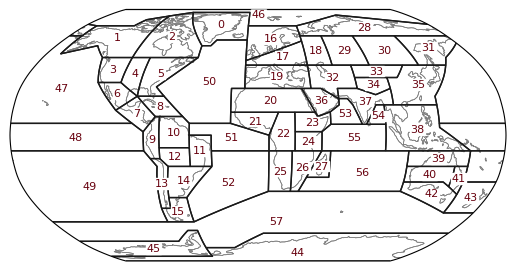

In [42]:
import regionmask
regionmask.__version__

import xarray as xr
xr.set_options(display_style="text")
xr.__version__

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
regs = [19,20]
np.set_printoptions(edgeitems=2)

regionmask.defined_regions.ar6

ar6_all = regionmask.defined_regions.ar6.all

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()))

text_kws = dict(color="#67000d", fontsize=8, bbox=dict(pad=0.2, color="w"))

ax = ar6_all.plot(
    ax=ax,
    add_ocean=False,
    line_kws=dict(linewidth=1),
    add_label=True,
   text_kws=text_kws,
)

ax.set_extent([-180, 180, -90, 90])
ax.coastlines(color="0.5", lw=0.5);

In [43]:
# land mask
ar6_land = regionmask.defined_regions.ar6.land

mask_3D_MIROC = ar6_land.mask_3D(land_mask_concat[0])

## JJA medit

Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


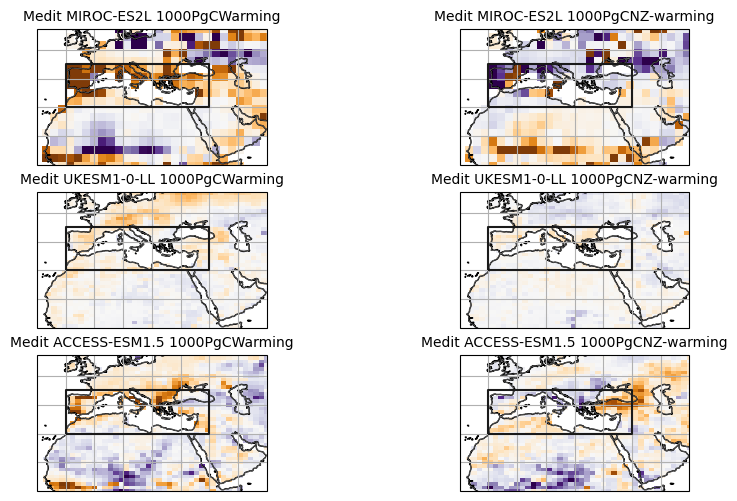

In [44]:
branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_1000_anom_JJA, concat_mrso_NZ_1000_anom_JJA,
                        land_mask_concat, member_str_names, branching_exp_str="1000PgC", season_str="JJA",
                                            lat_min=10, lat_max=50, lon_min=60, lon_max=340,
                                                        vmin=-150, vmax=150, title_region="Medit",
                                                    vmin_warming = -150, vmax_warming = 150,
                                           land_thresh=33, region_nums =[19, 43])


In [45]:
import matplotlib as mpl

Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


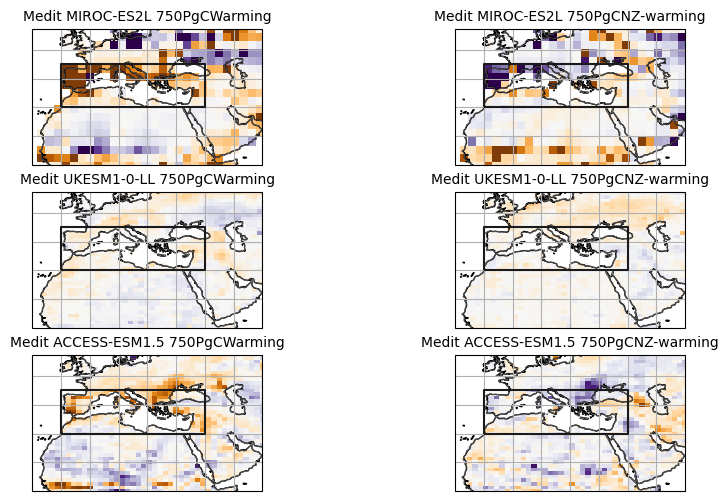

In [46]:
branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_750_anom_JJA, concat_mrso_NZ_750_anom_JJA,
                        land_mask_concat, member_str_names, branching_exp_str="750PgC", season_str="JJA",
                                            lat_min=10, lat_max=50, lon_min=60, lon_max=340,
                                                        vmin=-150, vmax=150, title_region="Medit",
                                                    vmin_warming = -150, vmax_warming = 150,
                                           land_thresh=33, region_nums =[19, 43])


Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


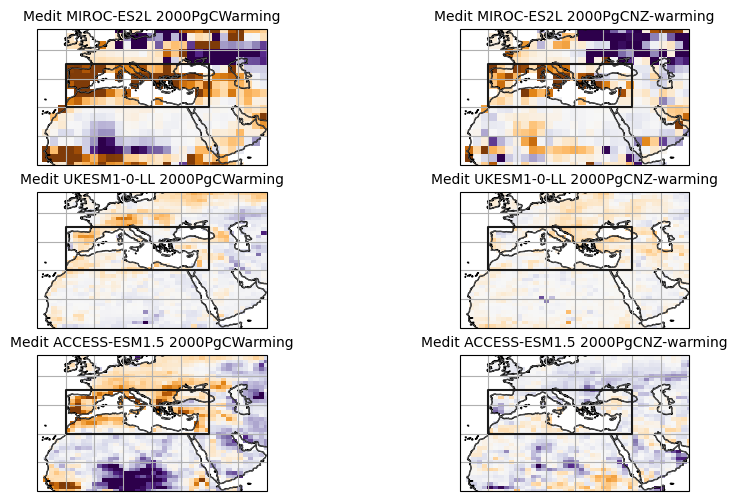

In [47]:
branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_2000_anom_JJA, concat_mrso_NZ_2000_anom_JJA,
                        land_mask_concat, member_str_names, branching_exp_str="2000PgC", season_str="JJA",
                                            lat_min=10, lat_max=50, lon_min=60, lon_max=340,
                                                        vmin=-150, vmax=150, title_region="Medit",
                                                    vmin_warming = -150, vmax_warming = 150,
                                           land_thresh=33, region_nums =[19, 43])


## DJF Southern Af

In [48]:
lon_min=60
lon_max=300
lat_min=-50 
lat_max=0

Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


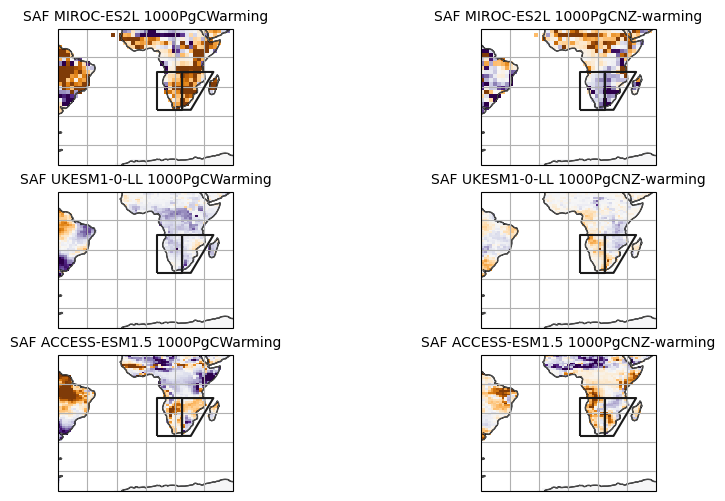

In [49]:
branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_1000_anom_DJF, concat_mrso_NZ_1000_anom_DJF,
                        land_mask_concat, member_str_names, branching_exp_str="1000PgC", season_str="DJF",
                                            lat_min=-60, lat_max=10, lon_min=60, lon_max=300,
                                                        vmin=-100, vmax=100, title_region="SAF",
                                                    vmin_warming = -100, vmax_warming = 100,
                                           land_thresh=33, region_nums =[19, 25, 26])


Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


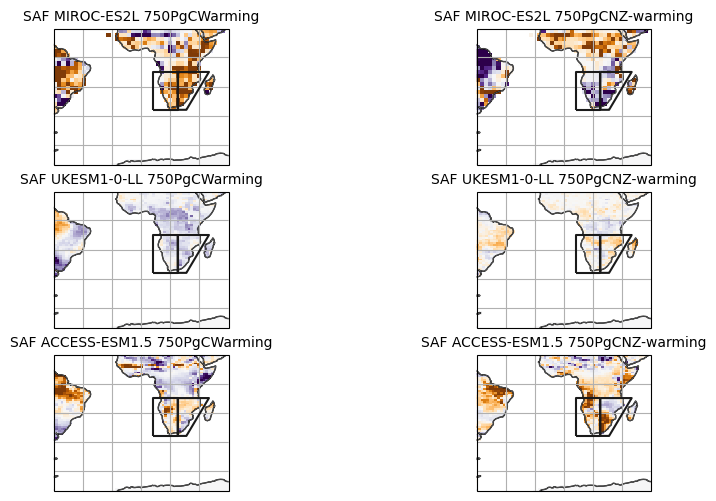

In [50]:
branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_750_anom_DJF, concat_mrso_NZ_750_anom_DJF,
                        land_mask_concat, member_str_names, branching_exp_str="750PgC", season_str="DJF",
                                            lat_min=-60, lat_max=10, lon_min=60, lon_max=300,
                                                        vmin=-100, vmax=100, title_region="SAF",
                                                    vmin_warming = -100, vmax_warming = 100,
                                           land_thresh=33, region_nums =[19, 25, 26])


Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


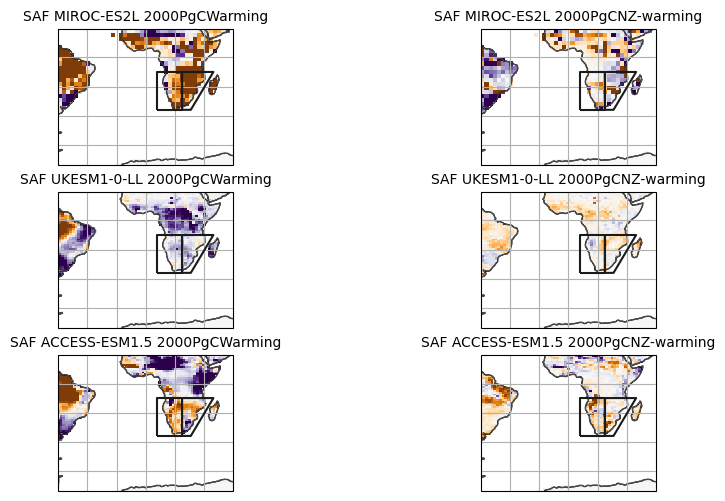

In [51]:
branch_mrso_grid_plot_warm_NZ_anoms_set_ext(concat_mrso_warming_2000_anom_DJF, concat_mrso_NZ_2000_anom_DJF,
                        land_mask_concat, member_str_names, branching_exp_str="2000PgC", season_str="DJF",
                                            lat_min=-60, lat_max=10, lon_min=60, lon_max=300,
                                                        vmin=-100, vmax=100, title_region="SAF",
                                                    vmin_warming = -100, vmax_warming = 100,
                                           land_thresh=33, region_nums =[19, 25, 26])


# No set ext, but seasonal mrso change plots

In [52]:
def branch_mrso_grid_plot_warm_NZ_anoms_seas_global(concat_mrso_warming_branch_anom_latlon, concat_mrso_NZ_branch_anom_latlon,
                        land_mask_concat, member_str_names, branching_exp_str, season_str,
                                                        lat_min, lat_max, lon_min, lon_max,
                                                        vmin, vmax, title_region, vmin_warming, vmax_warming):

    """

    plotting annual grid plots for temperature anomaly during warming, NZ, and difference
    
    """

    nrows = 3 # ensemble members
    ncols = 3 # warming anom, NZ anom, NZ-warming anom
    


    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(10,6))

    mrso_cmap = "PuOr"
    mrso_cmap_diff = "PuOr"


    mrso_NZ_minus_warming_annual_branch = []
    mrso_NZ_minus_warming_JJA_branch = []
    mrso_NZ_minus_warming_DJF_branch = []
    

    for member in range(len(concat_mrso_warming_branch_anom_latlon)):
        
        print("Warming phase plotting ANNUAL")

        mrso_warming_anom = concat_mrso_warming_branch_anom_latlon[member]
        
        mrso_warming_anom=mrso_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        A = mrso_warming_anom.mrso.plot(ax=axes[member,0],transform=ccrs.PlateCarree(),
                                        vmin=vmin_warming, vmax=vmax_warming,

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,0].coastlines()
        axes[member,0].gridlines()
        axes[member,0].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "Warming", fontsize=10)

    for member in range(len(concat_mrso_NZ_branch_anom_latlon)):
        
        print("NZ phase plotting ANNUAL")

        mrso_NZ_anom = concat_mrso_NZ_branch_anom_latlon[member]
        
        mrso_NZ_anom=mrso_NZ_anom.where(land_mask_concat[member].sftlf==100)
                
        A = mrso_NZ_anom.mrso.plot(ax=axes[member,1],transform=ccrs.PlateCarree(),
                                   vmin=vmin_warming, vmax=vmax_warming,

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,1].coastlines()
        axes[member,1].gridlines()
        axes[member,1].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "NZ", fontsize=10)

    for member in range(len(concat_mrso_NZ_branch_anom_latlon)):
        
        print("NZ-warming phase plotting ANNUAL, NZ anom")

        mrso_NZ_minus_warming_anom = concat_mrso_NZ_branch_anom_latlon[member]-concat_mrso_warming_branch_anom_latlon[member]
        
        mrso_NZ_minus_warming_anom=mrso_NZ_minus_warming_anom.where(land_mask_concat[member].sftlf==100)
        

        
        
        B = mrso_NZ_minus_warming_anom.mrso.plot(ax=axes[member,2],transform=ccrs.PlateCarree(),
                                                 vmin=vmin, vmax = vmax,

                                       cmap=mrso_cmap_diff, add_colorbar=False)
        
        axes[member,2].coastlines()
        axes[member,2].gridlines()
        axes[member,2].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "NZ-warming", fontsize=10)

    
    
    plt.colorbar(A, ax=axes[2,:2], label="Soil Moisture Anomaly (%) during " + season_str, location='bottom',
            pad=0.05)

    plt.colorbar(B, ax=axes[2,2], label="Soil Moisture Anomaly (%) during " + season_str, location='bottom',
            pad=0.05)

        

Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ phase plotting ANNUAL
NZ phase plotting ANNUAL
NZ phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


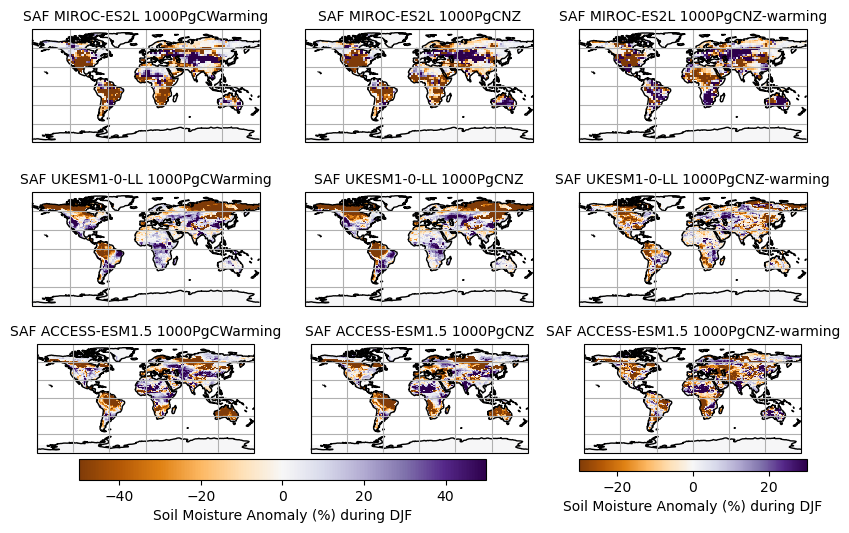

In [53]:
# DJF
branch_mrso_grid_plot_warm_NZ_anoms_seas_global(concat_mrso_warming_1000_anom_DJF, concat_mrso_NZ_1000_anom_DJF,
                        land_mask_concat, member_str_names, branching_exp_str="1000PgC", season_str="DJF",
                                            lat_min=-60, lat_max=0, lon_min=60, lon_max=260,
                                                        vmin=-30, vmax=30, title_region="SAF",
                                                    vmin_warming = -50, vmax_warming = 50)

Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
Warming phase plotting ANNUAL
NZ phase plotting ANNUAL
NZ phase plotting ANNUAL
NZ phase plotting ANNUAL
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom
NZ-warming phase plotting ANNUAL, NZ anom


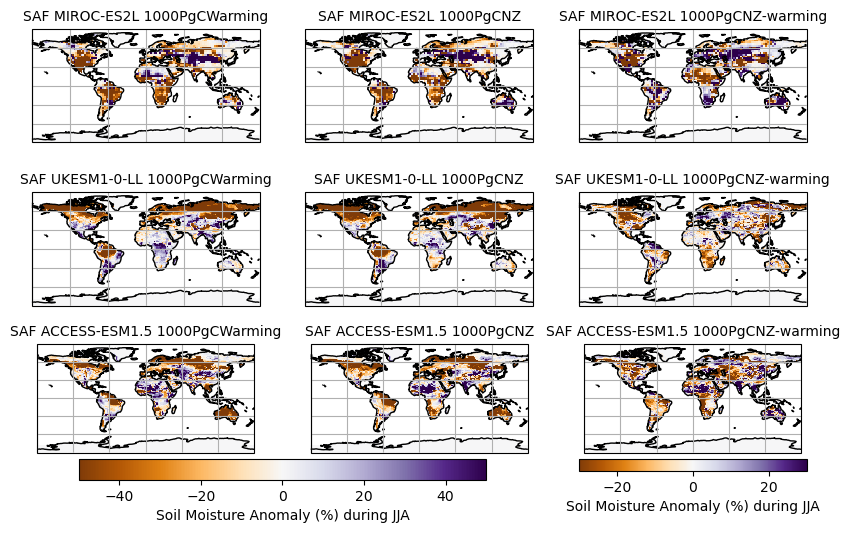

In [54]:
# JJA
branch_mrso_grid_plot_warm_NZ_anoms_seas_global(concat_mrso_warming_1000_anom_JJA, concat_mrso_NZ_1000_anom_JJA,
                        land_mask_concat, member_str_names, branching_exp_str="1000PgC", season_str="JJA",
                                            lat_min=-60, lat_max=0, lon_min=60, lon_max=260,
                                                        vmin=-30, vmax=30, title_region="SAF",
                                                    vmin_warming = -50, vmax_warming = 50)

In [55]:
def branch_mrso_grid_plot_seasonal_warm_NZ_anoms_set_ext(concat_mrso_warming_branch_anom_time_latlon, concat_mrso_NZ_branch_anom_time_latlon,
                        land_mask_concat, member_str_names, branching_exp_str, season_str,
                                                        lat_min, lat_max, lon_min, lon_max,
                                                        vmin, vmax, title_region, vmin_warming, vmax_warming):

    """

    plotting annual grid plots for temperature anomaly during warming, NZ, and difference
    
    """

    nrows = 3 # ensemble members
    ncols = 3 # warming anom, NZ anom, NZ-warming anom
    


    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(10,6))

    mrso_cmap = "PuOr"
    mrso_cmap_diff = "PuOr"


    mrso_NZ_minus_warming_annual_branch = []
    mrso_NZ_minus_warming_JJA_branch = []
    mrso_NZ_minus_warming_DJF_branch = []
    

    for member in range(len(concat_mrso_warming_branch_anom_time_latlon)):
        
        print("Warming phase plotting ANNUAL")

        mrso_warming_anom = concat_mrso_warming_branch_anom_time_latlon[member].mean(dim="time")
        
        mrso_warming_anom=mrso_warming_anom.where(land_mask_concat[member].sftlf==100)
        
        A = mrso_warming_anom.mrso.plot(ax=axes[member,0],transform=ccrs.PlateCarree(),
                                        vmin=vmin_warming, vmax=vmax_warming,

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,0].coastlines()
        axes[member,0].gridlines()
        axes[member,0].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "Warming", fontsize=10)
        axes[member,0].set_extent([lon_min, lon_max, lat_min, lat_max])


    for member in range(len(concat_mrso_NZ_branch_anom_time_latlon)):
        
        print("NZ phase plotting ANNUAL")

        mrso_NZ_anom = concat_mrso_NZ_branch_anom_time_latlon[member].mean(dim="time")
        
        mrso_NZ_anom=mrso_NZ_anom.where(land_mask_concat[member].sftlf==100)
                
        A = mrso_NZ_anom.mrso.plot(ax=axes[member,1],transform=ccrs.PlateCarree(),
                                   vmin=vmin_warming, vmax=vmax_warming,

                                       cmap=mrso_cmap, add_colorbar=False)
        
        axes[member,1].coastlines()
        axes[member,1].gridlines()
        axes[member,1].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "NZ", fontsize=10)
        axes[member,1].set_extent([lon_min, lon_max, lat_min, lat_max])

    for member in range(len(concat_mrso_NZ_branch_anom_time_latlon)):
        
        print("NZ-warming phase plotting ANNUAL, NZ anom")

        mrso_NZ_minus_warming_anom = concat_mrso_NZ_branch_anom_time_latlon[member].mean(dim="time")-concat_mrso_warming_branch_anom_time_latlon[member].groupby("time.season")[season_str].mean(dim="time")
        
        mrso_NZ_minus_warming_anom=mrso_NZ_minus_warming_anom.where(land_mask_concat[member].sftlf==100)
        

        
        
        B = mrso_NZ_minus_warming_anom.mrso.plot(ax=axes[member,2],transform=ccrs.PlateCarree(),
                                                 vmin=vmin, vmax = vmax,

                                       cmap=mrso_cmap_diff, add_colorbar=False)
        
        axes[member,2].coastlines()
        axes[member,2].gridlines()
        axes[member,2].set_title(title_region + " " + member_str_names[member]+ " " + branching_exp_str + "NZ-warming", fontsize=10)

        axes[member,2].set_extent([lon_min, lon_max, lat_min, lat_max])
    
    
    plt.colorbar(A, ax=axes[2,:2], label="Soil Moisture Anomaly (%) during " + season_str, location='bottom',
            pad=0.05)

    plt.colorbar(B, ax=axes[2,2], label="Soil Moisture Anomaly (%) during " + season_str, location='bottom',
            pad=0.05)

        

# precipitation and temperature correlation

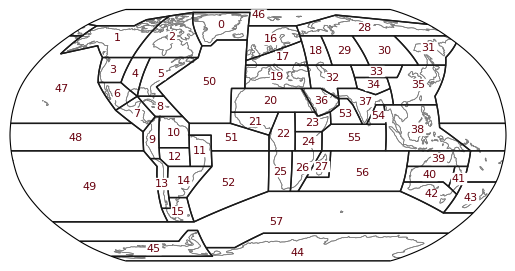

In [56]:
import regionmask
regionmask.__version__

import xarray as xr
xr.set_options(display_style="text")
xr.__version__

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(edgeitems=2)

regionmask.defined_regions.ar6

ar6_all = regionmask.defined_regions.ar6.all

ar6_all[38]

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()))

text_kws = dict(color="#67000d", fontsize=8, bbox=dict(pad=0.2, color="w"))

ax = ar6_all.plot(
    ax=ax,
    add_ocean=False,
    line_kws=dict(linewidth=1),

    text_kws=text_kws,
)

ax.coastlines(color="0.5", lw=0.5);

In [57]:
# land mask
ar6_land = regionmask.defined_regions.ar6.land


mask_3D_MIROC = ar6_land.mask_3D(land_MIROC)
mask_3D_MOHC = ar6_land.mask_3D(land_MOHC)
mask_3D_ACCESS = ar6_land.mask_3D(land_ACCESS_ESM15)

mask_3D_concat = [mask_3D_MIROC, 
                 mask_3D_MOHC,
                 mask_3D_ACCESS]


In [58]:
def region_data_pr(region_nums,
                         land_data_model, 
                         pr_data_lat_lon_full):

    """
    region_nums = [] filled with single number or multiple
    land_data_model = sftlf data for specific model
       pr_data_lat_lon_full = precipitation data for whole globe (lat,lon)

    -For lat lon anomalies
    
    """

    # 3D mask for land data for specific model
    mask_3D = ar6_land.mask_3D(land_data_model)

    region_data = mask_3D.sel(region=region_nums)

    data=pr_data_lat_lon_full.where(region_data)
    
    data_sum=data.sum(dim="region")
    pr_data = data_sum.pr
    
    
    return pr_data
    

In [59]:
def region_data_tas(region_nums,
                    land_data_model, 
                    tas_warming_data_lat_lon_full,
                   tas_NZ_data_lat_lon_full):

    """
    region_nums = [] filled with single number or multiple
    land_data_model = sftlf data for specific model
    var_data_lat_lon_full = temp or precipitation data for whole globe (lat,lon)

    -For lat lon anomalies
    
    """

    # 3D mask for land data for specific model
    mask_3D = ar6_land.mask_3D(land_data_model)

    region_data = mask_3D.sel(region=region_nums)

    data_warming=tas_warming_data_lat_lon_full.where(region_data)
    data_NZ = tas_NZ_data_lat_lon_full.where(region_data)
    
    data_warming_sum=data_warming.sum(dim="region")
    data_NZ_sum=data_NZ.sum(dim="region")

    data_anom=data_NZ_sum-data_warming_sum
    
    tas_data_anom = data_anom.tas

    tas_data_anom=tas_data_anom.where(land_data_model).sftlf
    
    return tas_data_anom

In [60]:
def region_data_pr(region_nums,
                    land_data_model, 
                    pr_warming_data_lat_lon_full,
                   pr_NZ_data_lat_lon_full):

    """
    region_nums = [] filled with single number or multiple
    land_data_model = sftlf data for specific model
    var_data_lat_lon_full = temp or precipitation data for whole globe (lat,lon)

    -For lat lon anomalies
    
    """

    # 3D mask for land data for specific model
    mask_3D = ar6_land.mask_3D(land_data_model)

    region_data = mask_3D.sel(region=region_nums)

    data_warming=pr_warming_data_lat_lon_full.where(region_data)
    data_NZ = pr_NZ_data_lat_lon_full.where(region_data)

    if len(region_nums)>1:
        # sum regions
        data_warming=data_warming.sum(dim="region")
        data_NZ=data_NZ.sum(dim="region")

    data_warming_pr = data_warming.pr
    data_NZ_pr = data_NZ.pr

    data_anom=data_NZ-data_warming
    pr_data_anom = data_anom.pr

    pr_data_NZ_minus_warming_anom=pr_data_anom.where(land_data_model).sftlf
    pr_data_warming_anom=data_warming_pr.where(land_data_model).sftlf
    pr_data_NZ_anom = data_NZ_pr.where(land_data_model).sftlf
    
    
    return pr_data_NZ_minus_warming_anom, pr_data_warming_anom, pr_data_NZ_anom

In [61]:
def region_data_tas(region_nums,
                    land_data_model, 
                    tas_warming_data_lat_lon_full,
                   tas_NZ_data_lat_lon_full):

    """
    region_nums = [] filled with single number or multiple
    land_data_model = sftlf data for specific model
    var_data_lat_lon_full = temp or tasecipitation data for whole globe (lat,lon)

    -For lat lon anomalies
    
    """

    # 3D mask for land data for specific model
    mask_3D = ar6_land.mask_3D(land_data_model)

    region_data = mask_3D.sel(region=region_nums)

    data_warming=tas_warming_data_lat_lon_full.where(region_data)
    data_NZ = tas_NZ_data_lat_lon_full.where(region_data)

    if len(region_nums)>1:
        # sum regions
        data_warming=data_warming.sum(dim="region")
        data_NZ=data_NZ.sum(dim="region")

    data_warming_tas = data_warming.tas
    data_NZ_tas = data_NZ.tas

    data_anom=data_NZ-data_warming
    tas_data_anom = data_anom.tas

    tas_data_NZ_minus_warming_anom=tas_data_anom.where(land_data_model).sftlf
    tas_data_warming_anom=data_warming_tas.where(land_data_model).sftlf
    tas_data_NZ_anom = data_NZ_tas.where(land_data_model).sftlf
    
    
    return tas_data_NZ_minus_warming_anom, tas_data_warming_anom, tas_data_NZ_anom


In [62]:
import scipy

In [63]:
def IQR_tas_pr_correlation(tas_flat, pr_flat):
    """
    Compute IQR for a tas-pr correlation.

    Goal is to plot out a box for IQRs in the correlation plots

    """
    import scipy

    # Compute mean
    mean_pr = np.nanmean(pr_flat)

    print("mean pr:")
    print(mean_pr)
    
    mean_tas = np.nanmean(tas_flat)

    print("mean tas:")
    print(mean_tas)
    


    # Compute IQR
    tas_IQR = scipy.stats.iqr(tas_flat, axis=None, rng=(25, 75), scale=1.0, nan_policy='omit', 
                interpolation='linear')

    print("IQR tas:")
    print(tas_IQR)

    pr_IQR = scipy.stats.iqr(pr_flat, axis=None, rng=(25, 75), scale=1.0, nan_policy='omit', 
                interpolation='linear')

    print("IQR pr:")
    print(pr_IQR)

    # Computing boxplot stats
    TL_tas = mean_tas-(0.5*tas_IQR)
    TL_pr = mean_pr+(0.5*pr_IQR)

    TR_tas = mean_tas+(0.5*tas_IQR)
    TR_pr = mean_pr+(0.5*pr_IQR)

    BL_tas = mean_tas-(0.5*tas_IQR)
    BL_pr = mean_pr-(0.5*pr_IQR)

    BR_tas = mean_tas+(0.5*tas_IQR)
    BR_pr = mean_pr-(0.5*pr_IQR)

    tas_box_coords = [TL_tas, TR_tas, BR_tas, BL_tas, TL_tas]
    pr_box_coords = [TL_pr, TR_pr, BR_pr, BL_pr, TL_pr]



    # Making a sample box plot
    plt.plot(tas_flat, pr_flat, '*')
    plt.plot(mean_tas, mean_pr, '+')
    plt.plot(tas_box_coords, pr_box_coords)


    return [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]

    

In [64]:
def IQR_tas_pr_correlation_embedded(tas_flat, pr_flat, figure_name,
                                   mean_marker_style, label, color):
    """
    Compute IQR for a tas-pr correlation.

    Goal is to plot out a box for IQRs in the correlation plots

    """
    import scipy

    # Compute mean
    mean_pr = np.nanmean(pr_flat)
    
    mean_tas = np.nanmean(tas_flat)
    
    # Compute IQR
    tas_IQR = scipy.stats.iqr(tas_flat, axis=None, rng=(25, 75), scale=1.0, nan_policy='omit', 
                interpolation='linear')

    pr_IQR = scipy.stats.iqr(pr_flat, axis=None, rng=(25, 75), scale=1.0, nan_policy='omit', 
                interpolation='linear')

    # Computing boxplot stats
    TL_tas = mean_tas-(0.5*tas_IQR)
    TL_pr = mean_pr+(0.5*pr_IQR)

    TR_tas = mean_tas+(0.5*tas_IQR)
    TR_pr = mean_pr+(0.5*pr_IQR)

    BL_tas = mean_tas-(0.5*tas_IQR)
    BL_pr = mean_pr-(0.5*pr_IQR)

    BR_tas = mean_tas+(0.5*tas_IQR)
    BR_pr = mean_pr-(0.5*pr_IQR)

    tas_box_coords = [TL_tas, TR_tas, BR_tas, BL_tas, TL_tas]
    pr_box_coords = [TL_pr, TR_pr, BR_pr, BL_pr, TL_pr]

    # Making a sample box plot
    figure_name.scatter(tas_flat, pr_flat, c=color, marker=mean_marker_style, alpha=0.1)
    figure_name.plot(mean_tas, mean_pr, color, marker=mean_marker_style, label=label)
    figure_name.plot(tas_box_coords, pr_box_coords, color)


    return [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]

# pr-tas relationships updt

In [65]:
def IQR_tas_pr_correlation_embedded_upt(tas_lat_lon_anom_da, pr_lat_lon_anom_da, ax,
                                       mean_marker_style, label, color, marker_size):
    """
    Compute IQR for a tas-pr correlation.

    Goal is to plot out a box for IQRs in the correlation plots

    """
    import scipy

    # flatten
    pr_flat=pr_lat_lon_anom_da.pr.to_numpy().flatten()
    tas_flat=tas_lat_lon_anom_da.tas.to_numpy().flatten()

    # Compute mean -- neglects nan vals
    mean_pr = np.nanmean(pr_flat)
    mean_tas = np.nanmean(tas_flat)
    

    # Compute IQR
    tas_IQR = scipy.stats.iqr(tas_flat, axis=None, rng=(25, 75), scale=1.0, nan_policy='omit', 
                interpolation='linear')

    pr_IQR = scipy.stats.iqr(pr_flat, axis=None, rng=(25, 75), scale=1.0, nan_policy='omit', 
                interpolation='linear')

    # Computing boxplot stats
    TL_tas = mean_tas-(0.5*tas_IQR)
    TL_pr = mean_pr+(0.5*pr_IQR)

    TR_tas = mean_tas+(0.5*tas_IQR)
    TR_pr = mean_pr+(0.5*pr_IQR)

    BL_tas = mean_tas-(0.5*tas_IQR)
    BL_pr = mean_pr-(0.5*pr_IQR)

    BR_tas = mean_tas+(0.5*tas_IQR)
    BR_pr = mean_pr-(0.5*pr_IQR)

    tas_box_coords = [TL_tas, TR_tas, BR_tas, BL_tas, TL_tas]
    pr_box_coords = [TL_pr, TR_pr, BR_pr, BL_pr, TL_pr]

    s=marker_size
    
    ax.scatter(mean_tas, mean_pr, s, color, marker=mean_marker_style, label=label)

    return [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]

In [66]:
def region_data_updt(region_nums,
                    land_data_model, 
                    data_lat_lon_all):

    """
    take in lat-lon dataset and extract regional data (lat,lon)
    
    """

    import regionmask
    regionmask.__version__
    
    import xarray as xr
    xr.set_options(display_style="text")
    xr.__version__
    
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import numpy as np
    
    np.set_printoptions(edgeitems=2)
    
    regionmask.defined_regions.ar6
    
    ar6_all = regionmask.defined_regions.ar6.all
    
    # land mask
    ar6_land = regionmask.defined_regions.ar6.land


    # 3D mask for land data for specific model
    mask_3D = ar6_land.mask_3D(land_data_model)
    region_data = mask_3D.sel(region=region_nums)

    data_lat_lon=data_lat_lon_all.where(region_data)

    if len(region_nums)>1:
        # sum regions
        data_lat_lon=data_lat_lon.sum(dim="region")


    region_data_lat_lon=data_lat_lon.where(land_data_model.sftlf)

    region_data_lat_lon_non_zero = region_data_lat_lon.where(region_data_lat_lon!=0)
    
    return region_data_lat_lon_non_zero


In [67]:
def pr_tas_correlation_regions(tas_concat_time_lat_lon_warming, pr_concat_time_lat_lon_warming,
                              tas_concat_time_lat_lon_NZ, pr_concat_time_lat_lon_NZ,
                              
                              tas_concat_time_lat_lon_piControl, pr_concat_time_lat_lon_piControl,
                              region_num_list, region_str_list, branch_title, save_string, model_str_list,
                              land_data_concat, color_list):

    """
    -Plot out regional pr-tas relationships for desired AR6 regions
            --Annual, JJA, DJF

    - This'll be for a single branching level for now
    
    """

    # Create fig

    nrows= len(region_num_list) # Number of rows is the number of regions to look at
    ncols = 6 # Ann, JJA, DJF for WC and NZ-WC

    
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        figsize=(12,12))

    # Loop through regions
    for region in range(len(region_num_list)):
        print("Region: " + region_str_list[region])

        # Loop through models
        for model in range(len(tas_concat_time_lat_lon_warming)):
        
            print("Model: " + model_str_list[model])


            # --------------------------- Annual calcs and plot for 1 region 3 models ------------------------
            # WC -  piControl
            row_num = region
            col_num = 0

            # piControl annual means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)

            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style='+', label=model_str_list[model], color=color_list[model])

          
        
            # NZ - WC
            row_num = region
            col_num = 1

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style='+', label=model_str_list[model], color=color_list[model])


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line


            print("DJF calcs")

            # --------------------------- DJF calcs and plot for 1 region 3 models ------------------------
            # WC -  piControl
            row_num = region
            col_num = 2

            # piControl DJF means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC DJF calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)
            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style='+', label=model_str_list[model], color=color_list[model])


            # NZ - WC
            row_num = region
            col_num = 3

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style='+', label=model_str_list[model], color=color_list[model])


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line


            

            # --------------------------- JJA calcs and plot for 1 region 3 models ------------------------
            print("JJA calcs")
            # WC -  piControl
            row_num = region
            col_num = 4

            # piControl DJF means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC DJF calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)
            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style='+', label=model_str_list[model], color=color_list[model])




            # NZ - WC
            row_num = region
            col_num = 5

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style='+', label=model_str_list[model], color=color_list[model])


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line


        

# Doing grid of plots with all three branching experiments

In [68]:
def pr_tas_correlation_regions_embed(tas_concat_time_lat_lon_warming, pr_concat_time_lat_lon_warming,
                              tas_concat_time_lat_lon_NZ, pr_concat_time_lat_lon_NZ,
                              
                              tas_concat_time_lat_lon_piControl, pr_concat_time_lat_lon_piControl,
                              region_num_list, region_str_list, branch_title, save_string, model_str_list,
                              land_data_concat, color_list, marker, fig, axes):

    """
    -Plot out regional pr-tas relationships for desired AR6 regions
            --Annual, JJA, DJF

    - This'll be for a single branching level for now
    
    """

    # Create fig
    marker_size=100
    

    # Loop through regions
    for region in range(len(region_num_list)):
        print("Region: " + region_str_list[region])

        # Loop through models
        for model in range(len(tas_concat_time_lat_lon_warming)):

            
            print("DJF calcs")

            # --------------------------- DJF calcs and plot for 1 region 3 models ------------------------
            # WC -  piControl
            row_num = region
            col_num = 2

            # piControl DJF means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC DJF calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model]+ " " + branch_title, color=color_list[model], marker_size=marker_size)


            # NZ - WC
            row_num = region
            col_num = 3

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model]+ " " + branch_title, color=color_list[model], marker_size=marker_size)


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line


            
            
            # --------------------------- JJA calcs and plot for 1 region 3 models ------------------------
            print("JJA calcs")
            # WC -  piControl
            row_num = region
            col_num = 4

            # piControl DJF means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC DJF calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)
            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model], color=color_list[model], marker_size=marker_size)




            # NZ - WC
            row_num = region
            col_num = 5

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model], color=color_list[model], marker_size=marker_size)


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line
            


        

In [69]:
def pr_tas_correlation_regions_embed(tas_concat_time_lat_lon_warming, pr_concat_time_lat_lon_warming,
                              tas_concat_time_lat_lon_NZ, pr_concat_time_lat_lon_NZ,
                              
                              tas_concat_time_lat_lon_piControl, pr_concat_time_lat_lon_piControl,
                              region_num_list, region_str_list, branch_title, save_string, model_str_list,
                              land_data_concat, color_list, marker, fig, axes):

    """
    -Plot out regional pr-tas relationships for desired AR6 regions
            --Annual, JJA, DJF

    - This'll be for a single branching level for now
    
    """

    # Create fig
    marker_size=250
    

    # Loop through regions
    for region in range(len(region_num_list)):
        print("Region: " + region_str_list[region])

        # Loop through models
        for model in range(len(tas_concat_time_lat_lon_warming)):

            print("DJF calcs")

            # --------------------------- DJF calcs and plot for 1 region 3 models ------------------------
            # WC -  piControl
            row_num = region
            col_num = 0

            # piControl DJF means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC DJF calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model]+ " " + branch_title, color=color_list[model], marker_size=marker_size)


            # NZ - WC
            row_num = region
            col_num = 1

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].groupby('time.season')["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model]+ " " + branch_title, color=color_list[model], marker_size=marker_size)


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line


            
            
            # --------------------------- JJA calcs and plot for 1 region 3 models ------------------------
            print("JJA calcs")
            # WC -  piControl
            row_num = region
            col_num = 2

            # piControl DJF means
            tas_piControl_lat_lon_mean = tas_concat_time_lat_lon_piControl[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_piControl_lat_lon_mean = pr_concat_time_lat_lon_piControl[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")

            # WC DJF calcs and anomaly
            tas_WC_lat_lon_mean = tas_concat_time_lat_lon_warming[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_WC_lat_lon_mean = pr_concat_time_lat_lon_warming[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            
            tas_WC_lat_lon_mean_anom = tas_WC_lat_lon_mean-tas_piControl_lat_lon_mean
            pr_WC_lat_lon_mean_anom = 100*(pr_WC_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean

            # extracting region data only
            tas_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_WC_lat_lon_mean_anom)

            pr_WC_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_WC_lat_lon_mean_anom)
            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_WC_lat_lon_mean_anom_region, 
                                                                 pr_WC_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model], color=color_list[model], marker_size=marker_size)




            # NZ - WC
            row_num = region
            col_num = 3

            # NZ calcs and anomaly
            tas_NZ_lat_lon_mean = tas_concat_time_lat_lon_NZ[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
            pr_NZ_lat_lon_mean = pr_concat_time_lat_lon_NZ[model].groupby('time.season')["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")

            tas_NZ_lat_lon_mean_anom = tas_NZ_lat_lon_mean-tas_WC_lat_lon_mean

            # pct change during NZ minus percent change during WC
            pr_NZ_lat_lon_mean_anom = 100*(pr_NZ_lat_lon_mean-pr_piControl_lat_lon_mean)/pr_piControl_lat_lon_mean - pr_WC_lat_lon_mean_anom


            tas_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=tas_NZ_lat_lon_mean_anom)

            pr_NZ_lat_lon_mean_anom_region=region_data_updt(region_nums=region_num_list[region],
                    land_data_model=land_data_concat[model], 
                    data_lat_lon_all=pr_NZ_lat_lon_mean_anom)

            
            [mean_pr, mean_tas, 
            tas_IQR, pr_IQR]=IQR_tas_pr_correlation_embedded_upt(tas_NZ_lat_lon_mean_anom_region, 
                                                                 pr_NZ_lat_lon_mean_anom_region, ax=axes[row_num, col_num],
                                                                mean_marker_style=marker, label=model_str_list[model], color=color_list[model], marker_size=marker_size)


            axes[row_num, col_num].vlines(0, -30, 30, colors='k', linestyles='dashed') # vertical line
            axes[row_num, col_num].hlines(0, -2, 2, colors='k', linestyles='dashed') # horizontal line
            


        

In [70]:
def create_full_grid_plot_three_branches(marker_list, number_regions):

    """

    Create figure and then run the 750, 1000, 2000 PgC plotting functions

    marker_list = list of markers for 750, 1000, 2000PgC -> ["+" "*", "x"] --> look into adding strings e.g. $750PgC$
    
    """

    nrows= number_regions # Number of rows is the number of regions to look at
    #ncols = 4 # Ann, JJA, DJF for WC and NZ-WC

    ncols = 4 # Ann, JJA, DJF for WC and NZ-WC ---> this was woking. Playing with this now

    
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        figsize=(20,20))
    marker_size=250

    # --------------------------------------Running 750PgC calcs------------------------------
    marker=marker_list[0]

    tas_concat_time_lat_lon_warming = concat_tas_warming_750
    pr_concat_time_lat_lon_warming = concat_pr_warming_750
    tas_concat_time_lat_lon_NZ = concat_tas_NZ_750
    pr_concat_time_lat_lon_NZ = concat_pr_NZ_750
    tas_concat_time_lat_lon_piControl=concat_tas_piControl
    pr_concat_time_lat_lon_piControl=concat_pr_piControl
    region_num_list = [[25, 26], [19]]
    #region_num_list = [[25, 26]]
    region_str_list=["Southern Africa", "Mediterranean"]
    branch_title="750PgC"
    save_string=branch_title
    model_str_list=member_str_names
    land_data_concat=land_mask_concat
    color_list=["green", "red", "blue"]

    
    pr_tas_correlation_regions_embed(tas_concat_time_lat_lon_warming, 
                               pr_concat_time_lat_lon_warming,
                               tas_concat_time_lat_lon_NZ, 
                                pr_concat_time_lat_lon_NZ,
                                tas_concat_time_lat_lon_piControl, 
                                 pr_concat_time_lat_lon_piControl,
                                 region_num_list, 
                                 region_str_list, 
                                  branch_title, 
                                  save_string, 
                                model_str_list,
                               land_data_concat, 
                               color_list, marker, fig, axes)
    
        
    
    # --------------------------------------Running 1000PgC calcs------------------------------
    marker=marker_list[1]

    tas_concat_time_lat_lon_warming = concat_tas_warming_1000
    pr_concat_time_lat_lon_warming = concat_pr_warming_1000
    tas_concat_time_lat_lon_NZ = concat_tas_NZ_1000
    pr_concat_time_lat_lon_NZ = concat_pr_NZ_1000
    tas_concat_time_lat_lon_piControl=concat_tas_piControl
    pr_concat_time_lat_lon_piControl=concat_pr_piControl
    region_num_list = [[25, 26], [19]]
    #region_num_list = [[25, 26]]
    region_str_list=["Southern Africa", "Mediterranean"]
    branch_title="1000PgC"
    save_string=branch_title
    model_str_list=member_str_names
    land_data_concat=land_mask_concat
    color_list=["green", "red", "blue"]
    
    
    pr_tas_correlation_regions_embed(tas_concat_time_lat_lon_warming, 
                               pr_concat_time_lat_lon_warming,
                               tas_concat_time_lat_lon_NZ, 
                                pr_concat_time_lat_lon_NZ,
                                tas_concat_time_lat_lon_piControl, 
                                 pr_concat_time_lat_lon_piControl,
                                 region_num_list, 
                                 region_str_list, 
                                  branch_title, 
                                  save_string, 
                                model_str_list,
                               land_data_concat, 
                               color_list, marker, fig, axes)
    
        
    # --------------------------------------Running 2000PgC calcs------------------------------
    marker=marker_list[2]

    tas_concat_time_lat_lon_warming = concat_tas_warming_2000
    pr_concat_time_lat_lon_warming = concat_pr_warming_2000
    tas_concat_time_lat_lon_NZ = concat_tas_NZ_2000
    pr_concat_time_lat_lon_NZ = concat_pr_NZ_2000
    tas_concat_time_lat_lon_piControl=concat_tas_piControl
    pr_concat_time_lat_lon_piControl=concat_pr_piControl
    region_num_list = [[25, 26], [19]]
    #region_num_list = [[25, 26]]
    region_str_list=["Southern Africa", "Mediterranean"]
    branch_title="2000PgC"
    save_string=branch_title
    model_str_list=member_str_names
    land_data_concat=land_mask_concat
    color_list=["green", "red", "blue"]
    
    
    pr_tas_correlation_regions_embed(tas_concat_time_lat_lon_warming, 
                               pr_concat_time_lat_lon_warming,
                               tas_concat_time_lat_lon_NZ, 
                                pr_concat_time_lat_lon_NZ,
                                tas_concat_time_lat_lon_piControl, 
                                 pr_concat_time_lat_lon_piControl,
                                 region_num_list, 
                                 region_str_list, 
                                  branch_title, 
                                  save_string, 
                                model_str_list,
                               land_data_concat, 
                               color_list, marker, fig, axes)


    return fig, axes

    

Region: Southern Africa
DJF calcs
JJA calcs
DJF calcs
JJA calcs
DJF calcs
JJA calcs
Region: Mediterranean
DJF calcs
JJA calcs
DJF calcs
JJA calcs
DJF calcs
JJA calcs
Region: Southern Africa
DJF calcs
JJA calcs
DJF calcs
JJA calcs
DJF calcs
JJA calcs
Region: Mediterranean
DJF calcs
JJA calcs
DJF calcs
JJA calcs
DJF calcs
JJA calcs
Region: Southern Africa
DJF calcs
JJA calcs
DJF calcs
JJA calcs
DJF calcs
JJA calcs
Region: Mediterranean
DJF calcs
JJA calcs
DJF calcs
JJA calcs
DJF calcs
JJA calcs


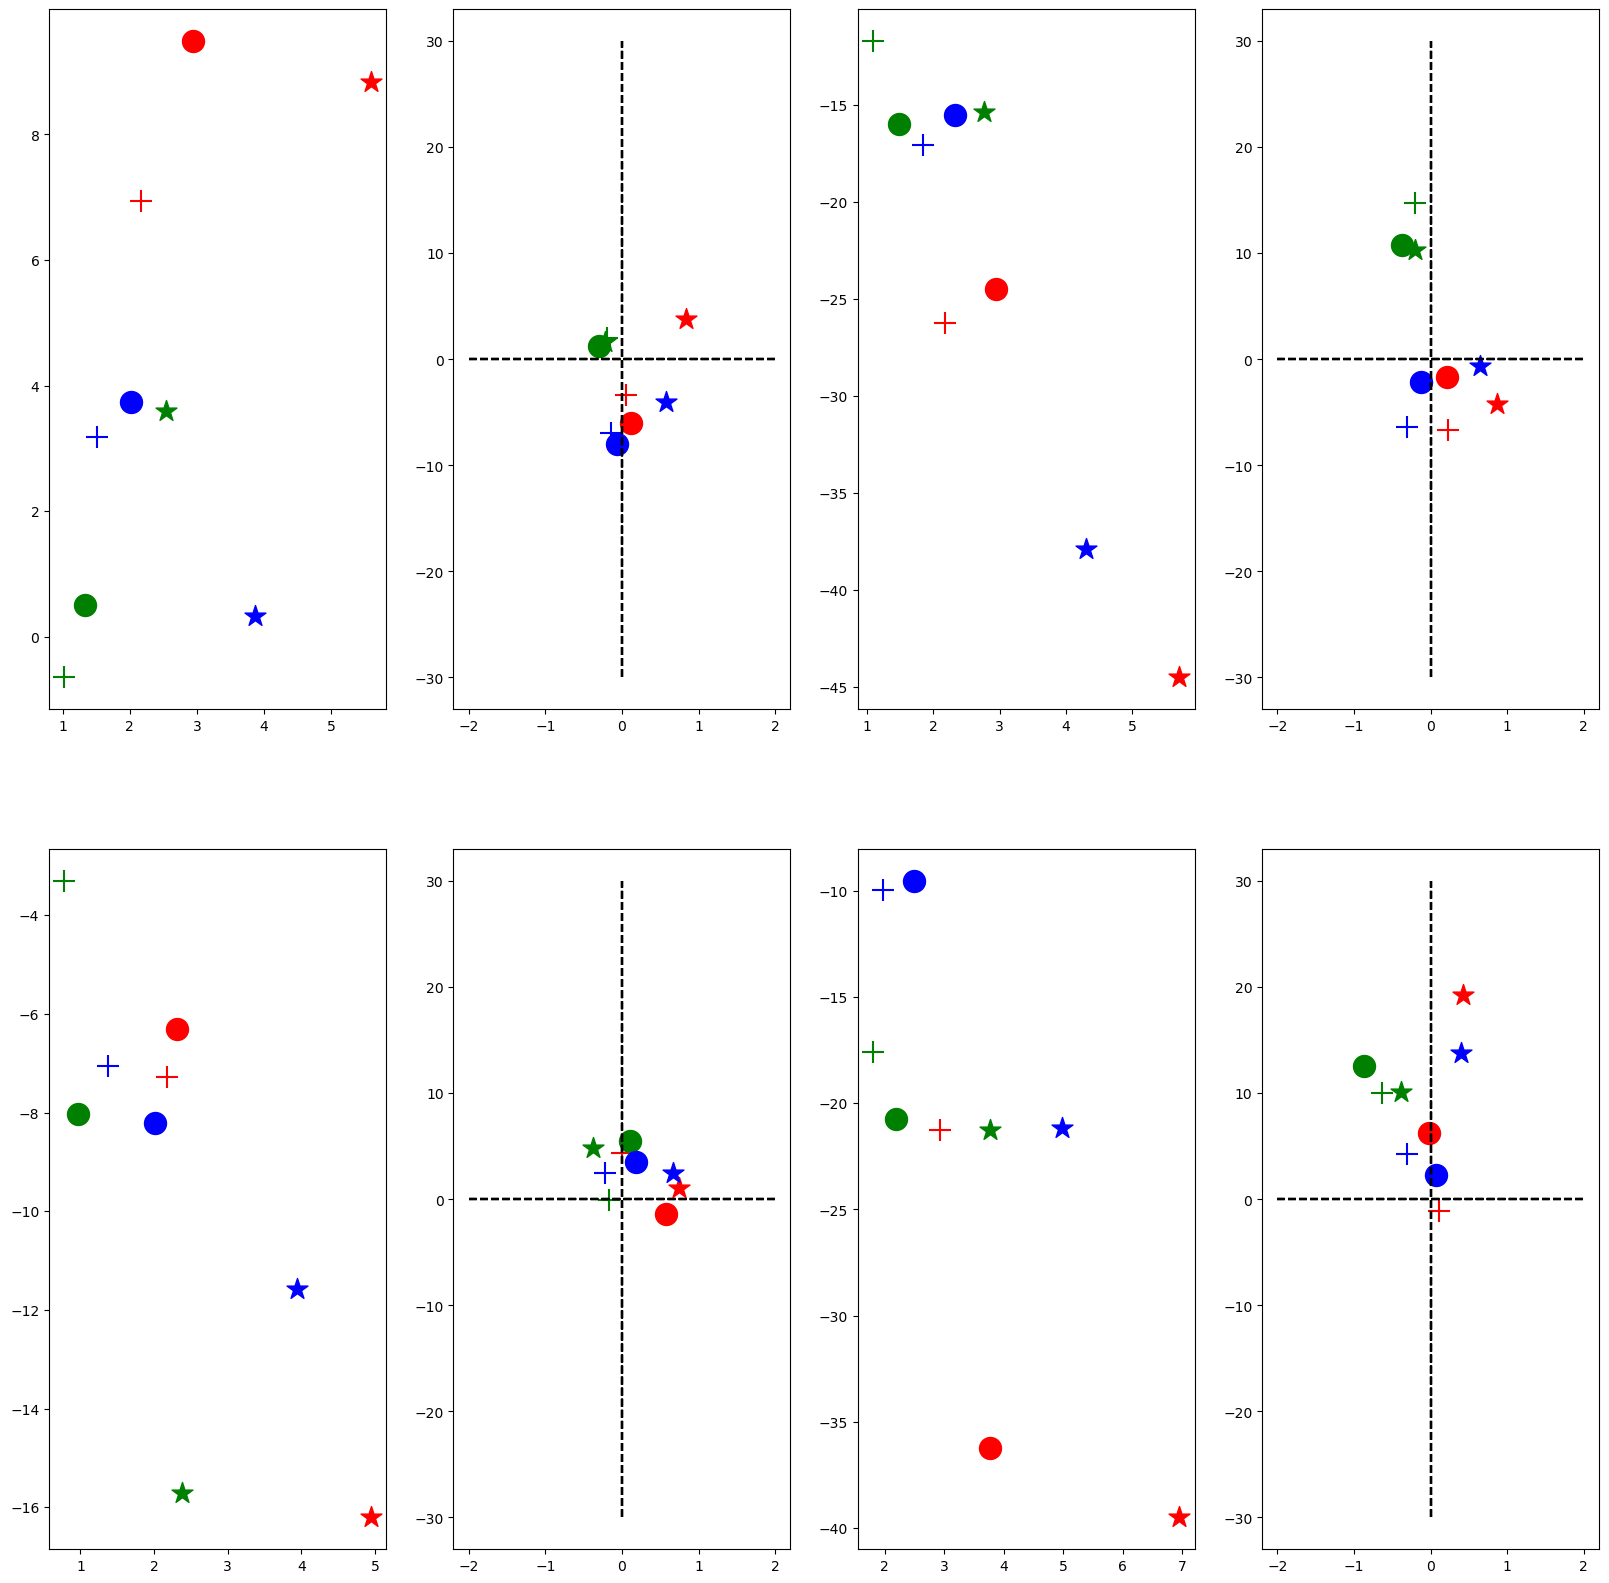

In [71]:
marker_list=["+", "o", "*"]

fig,axes = create_full_grid_plot_three_branches(marker_list, number_regions=2)

In [72]:
# Top row - y limits
axes[0,0].set_ylim([-12, 12])
axes[0,1].set_ylim([-20, 20])
axes[0,2].set_ylim([-50, 50])
axes[0,3].set_ylim([-20, 20])

(-20.0, 20.0)

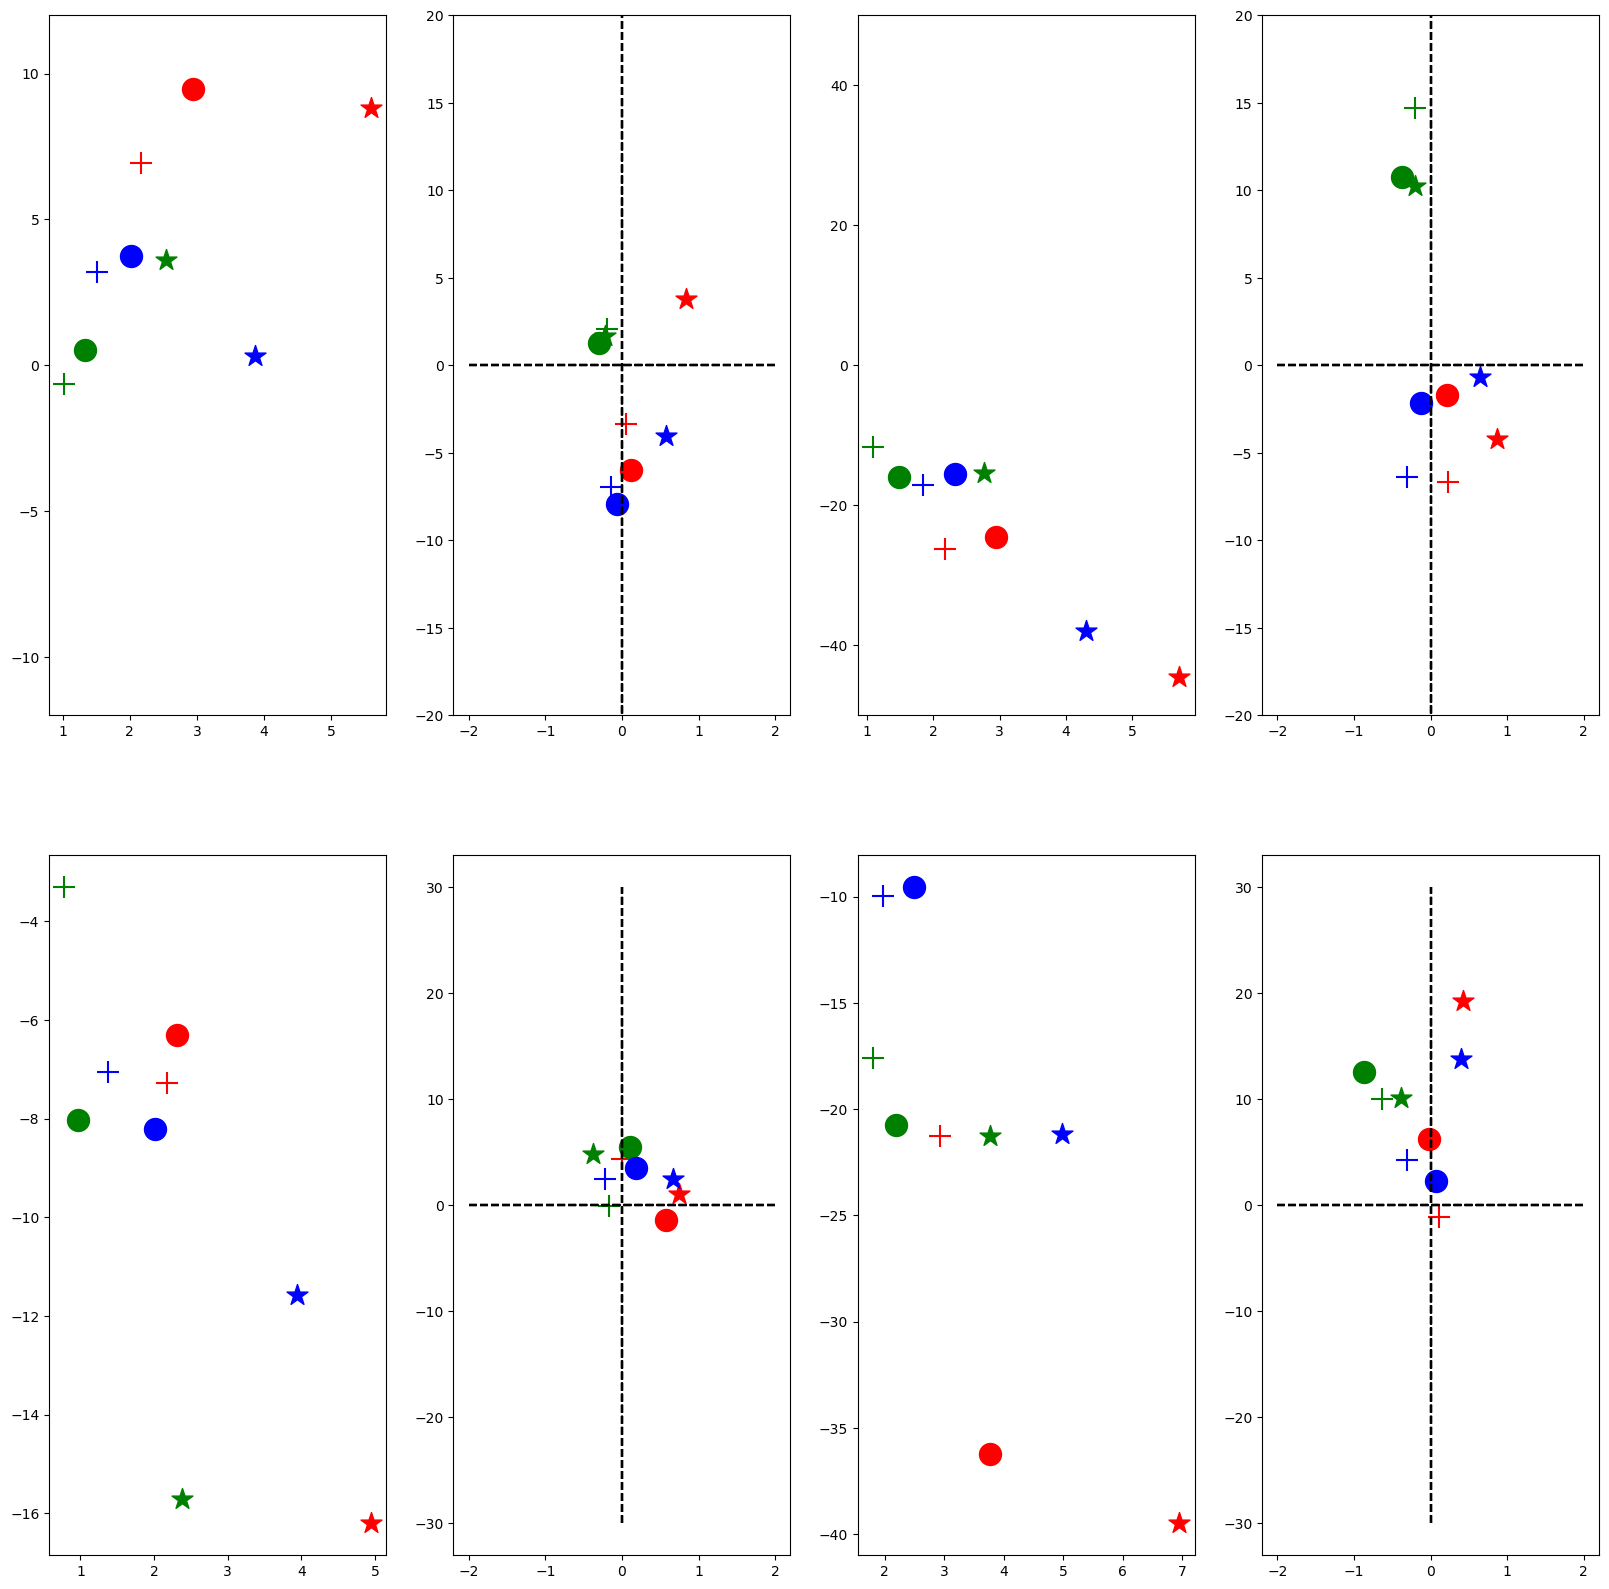

In [73]:
fig

In [74]:
# Top row - x limits
axes[0,0].set_xlim([0, 7])
axes[0,1].set_xlim([-1.5, 1.5])
axes[0,2].set_xlim([0, 7])
axes[0,3].set_xlim([-1.5, 1.5])

(-1.5, 1.5)

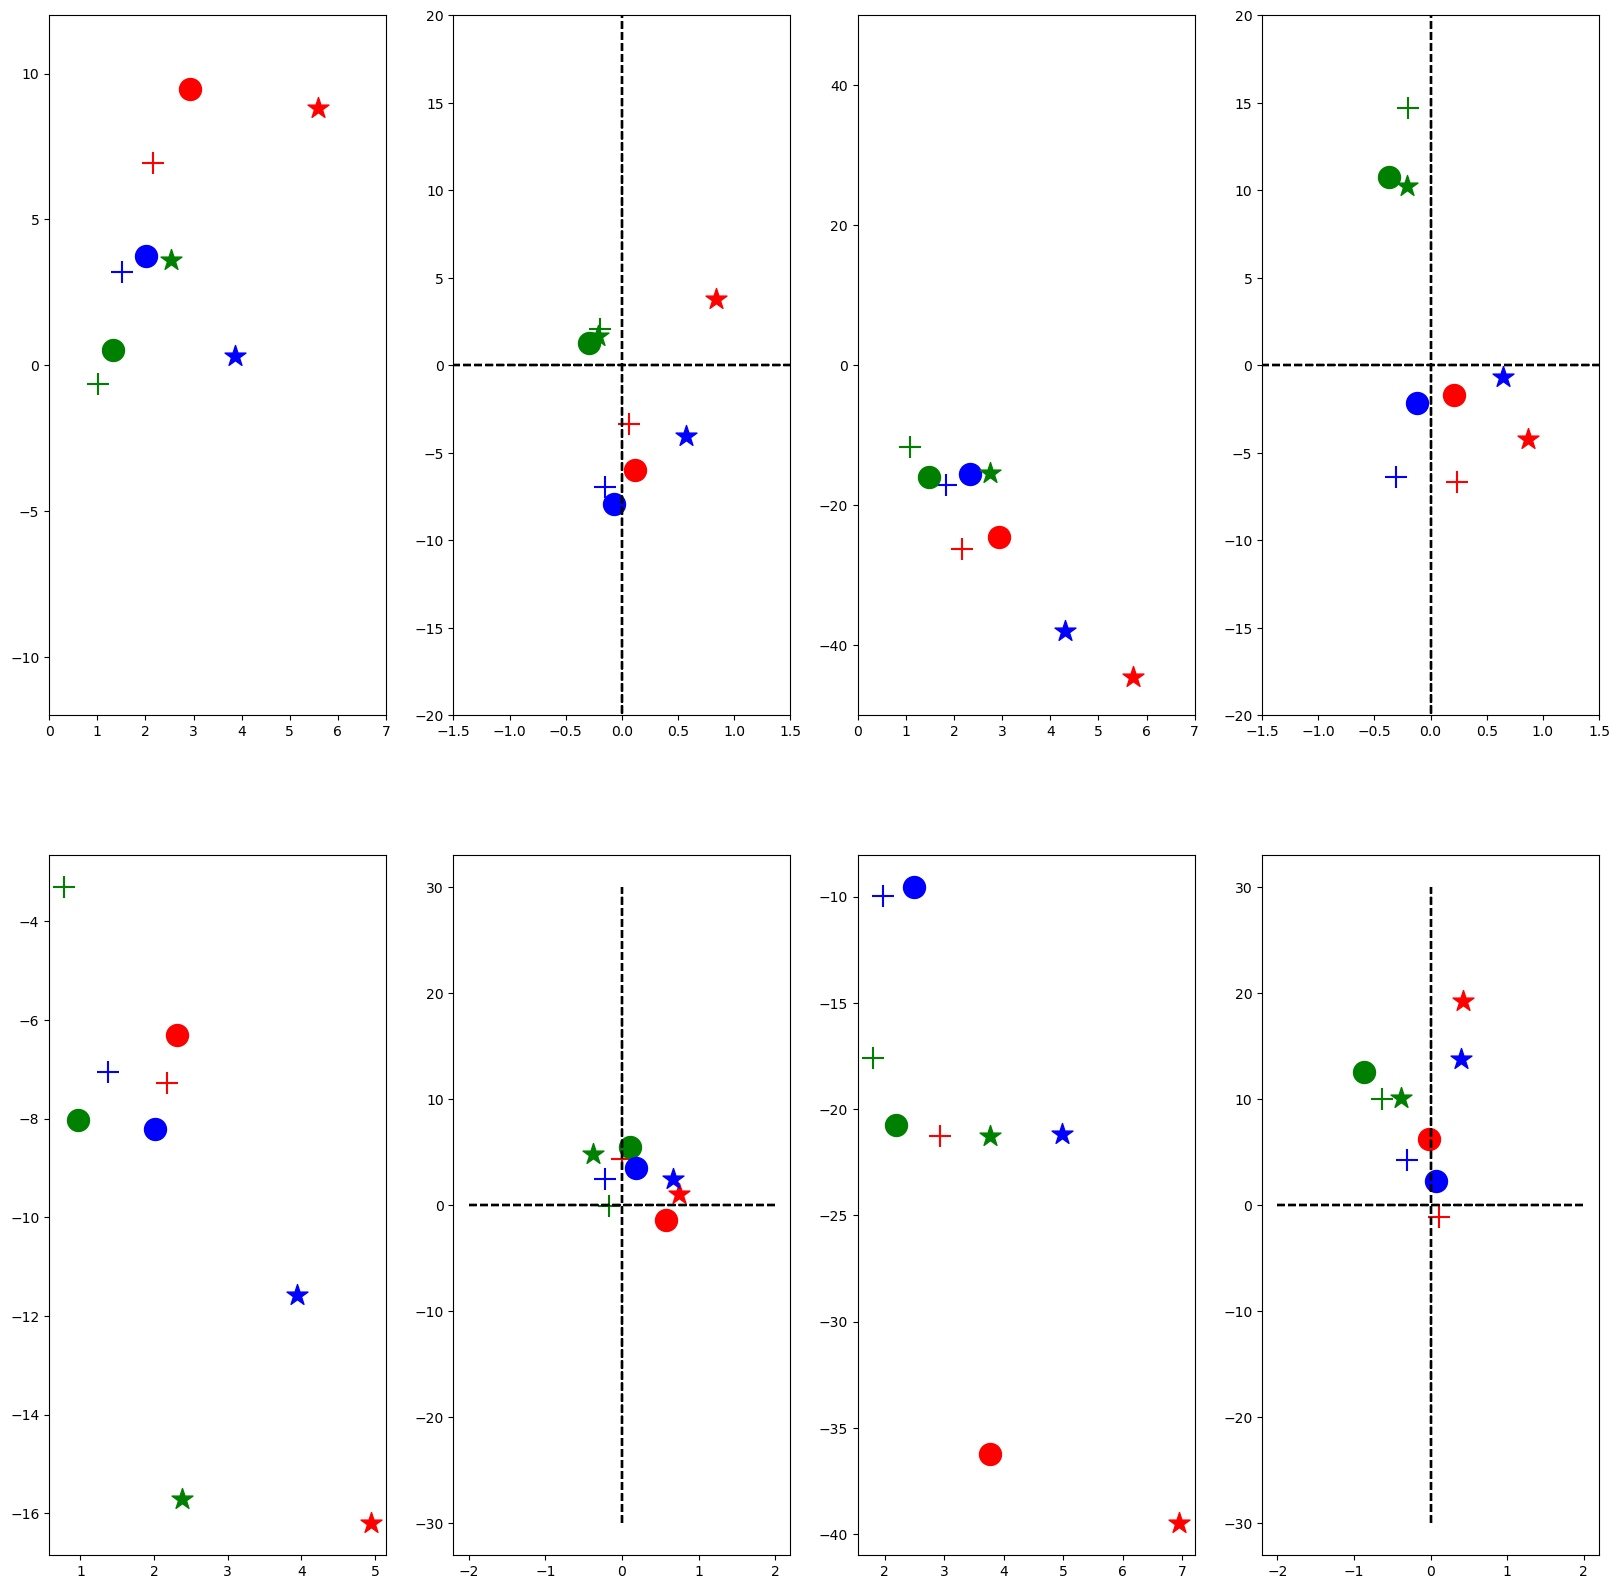

In [75]:
fig

In [76]:
# second row ylims
axes[1,0].set_ylim([-20, 0])
axes[1,1].set_ylim([-10, 10])
axes[1,2].set_ylim([-45, 0])
axes[1,3].set_ylim([-25, 25])

(-25.0, 25.0)

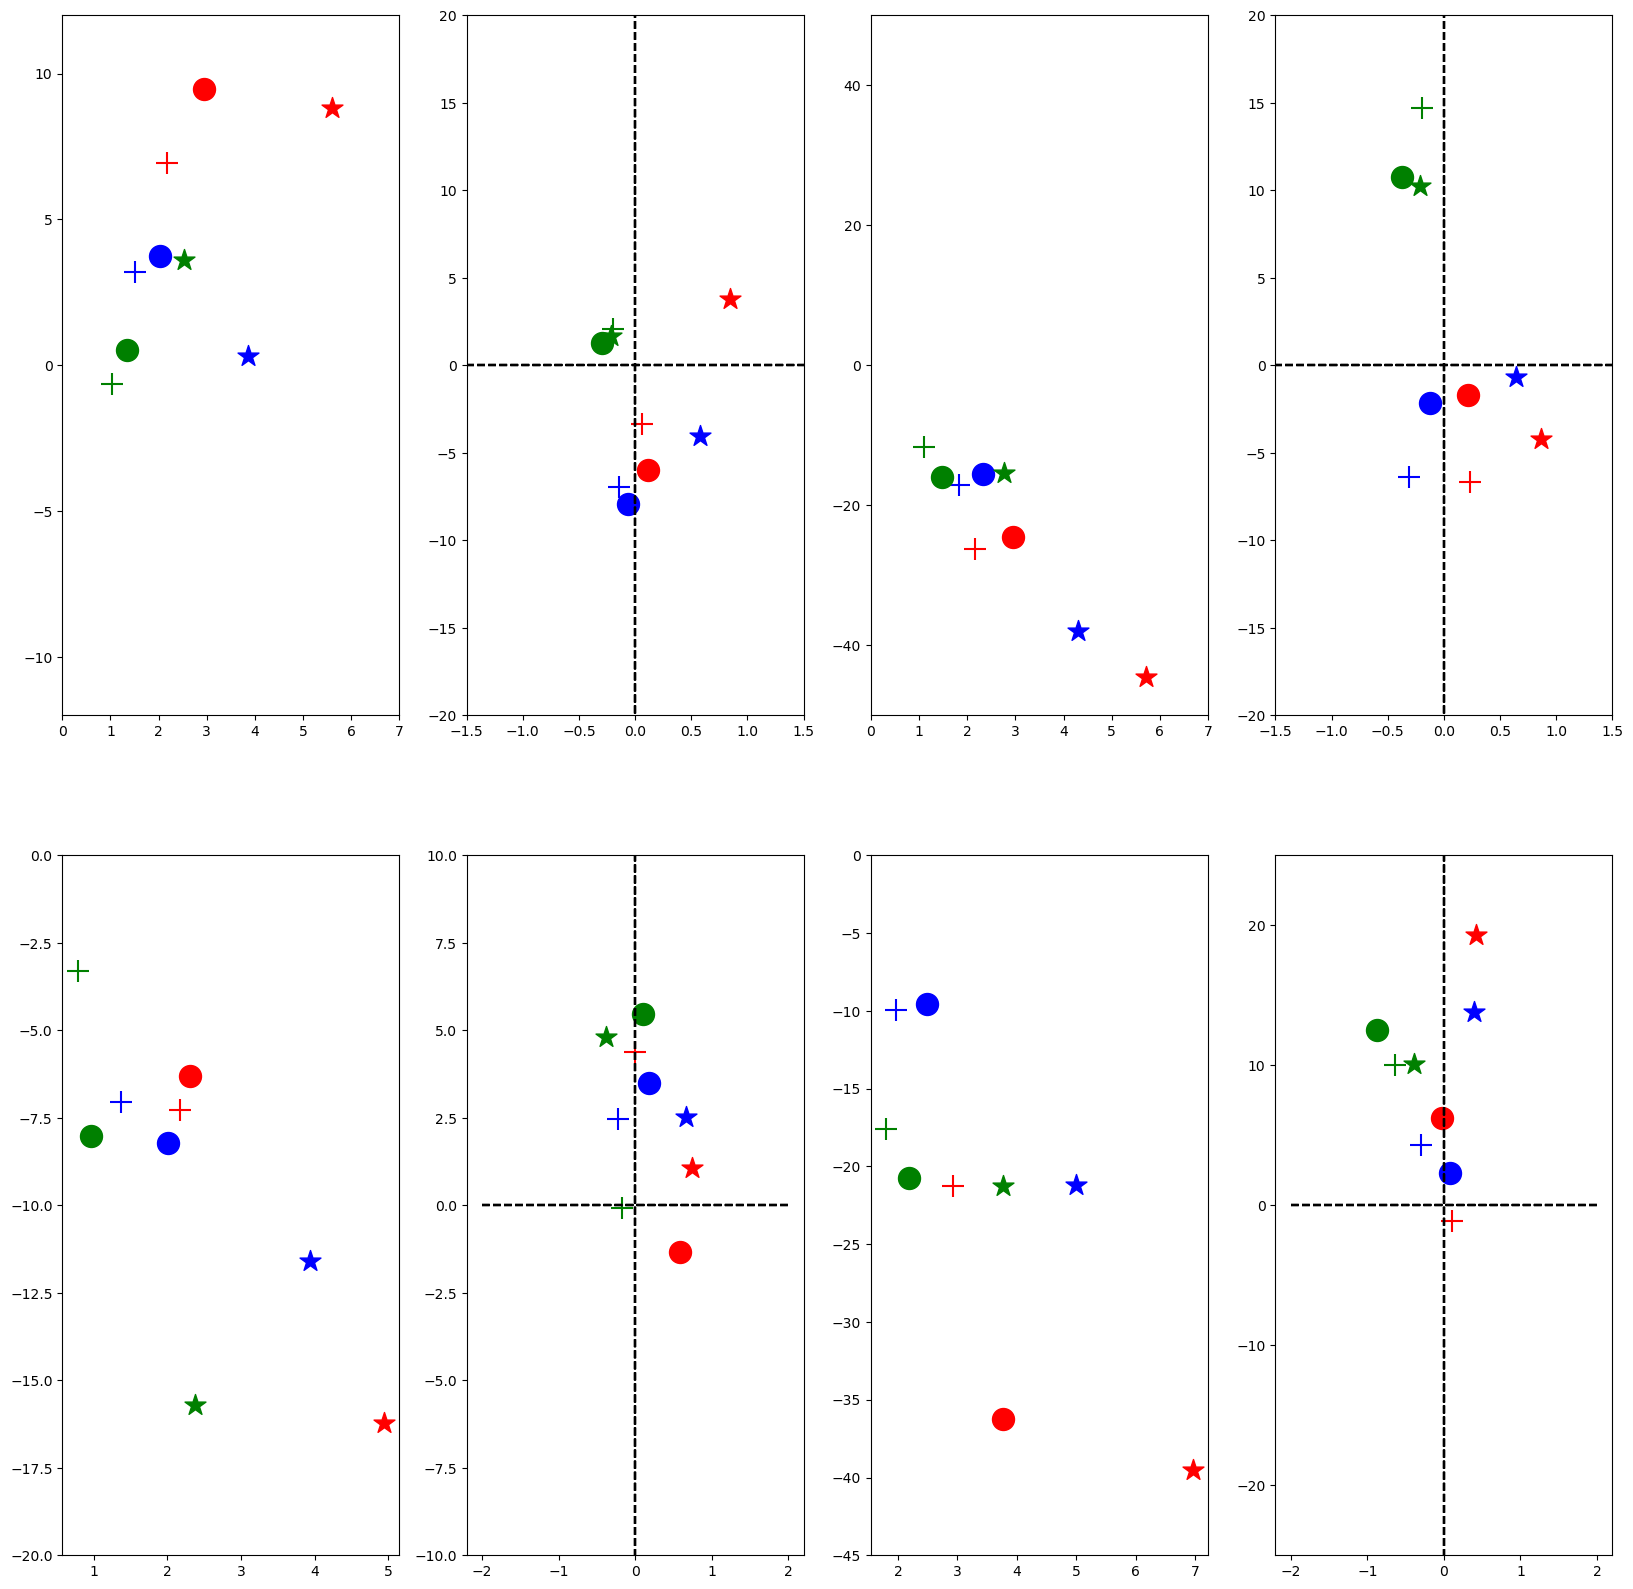

In [77]:
fig

In [78]:
# second row xlims
axes[1,0].set_xlim([0, 6])
axes[1,1].set_xlim([-1.5, 1.5])
axes[1,2].set_xlim([0, 8])
axes[1,3].set_xlim([-1.5, 1.5])

(-1.5, 1.5)

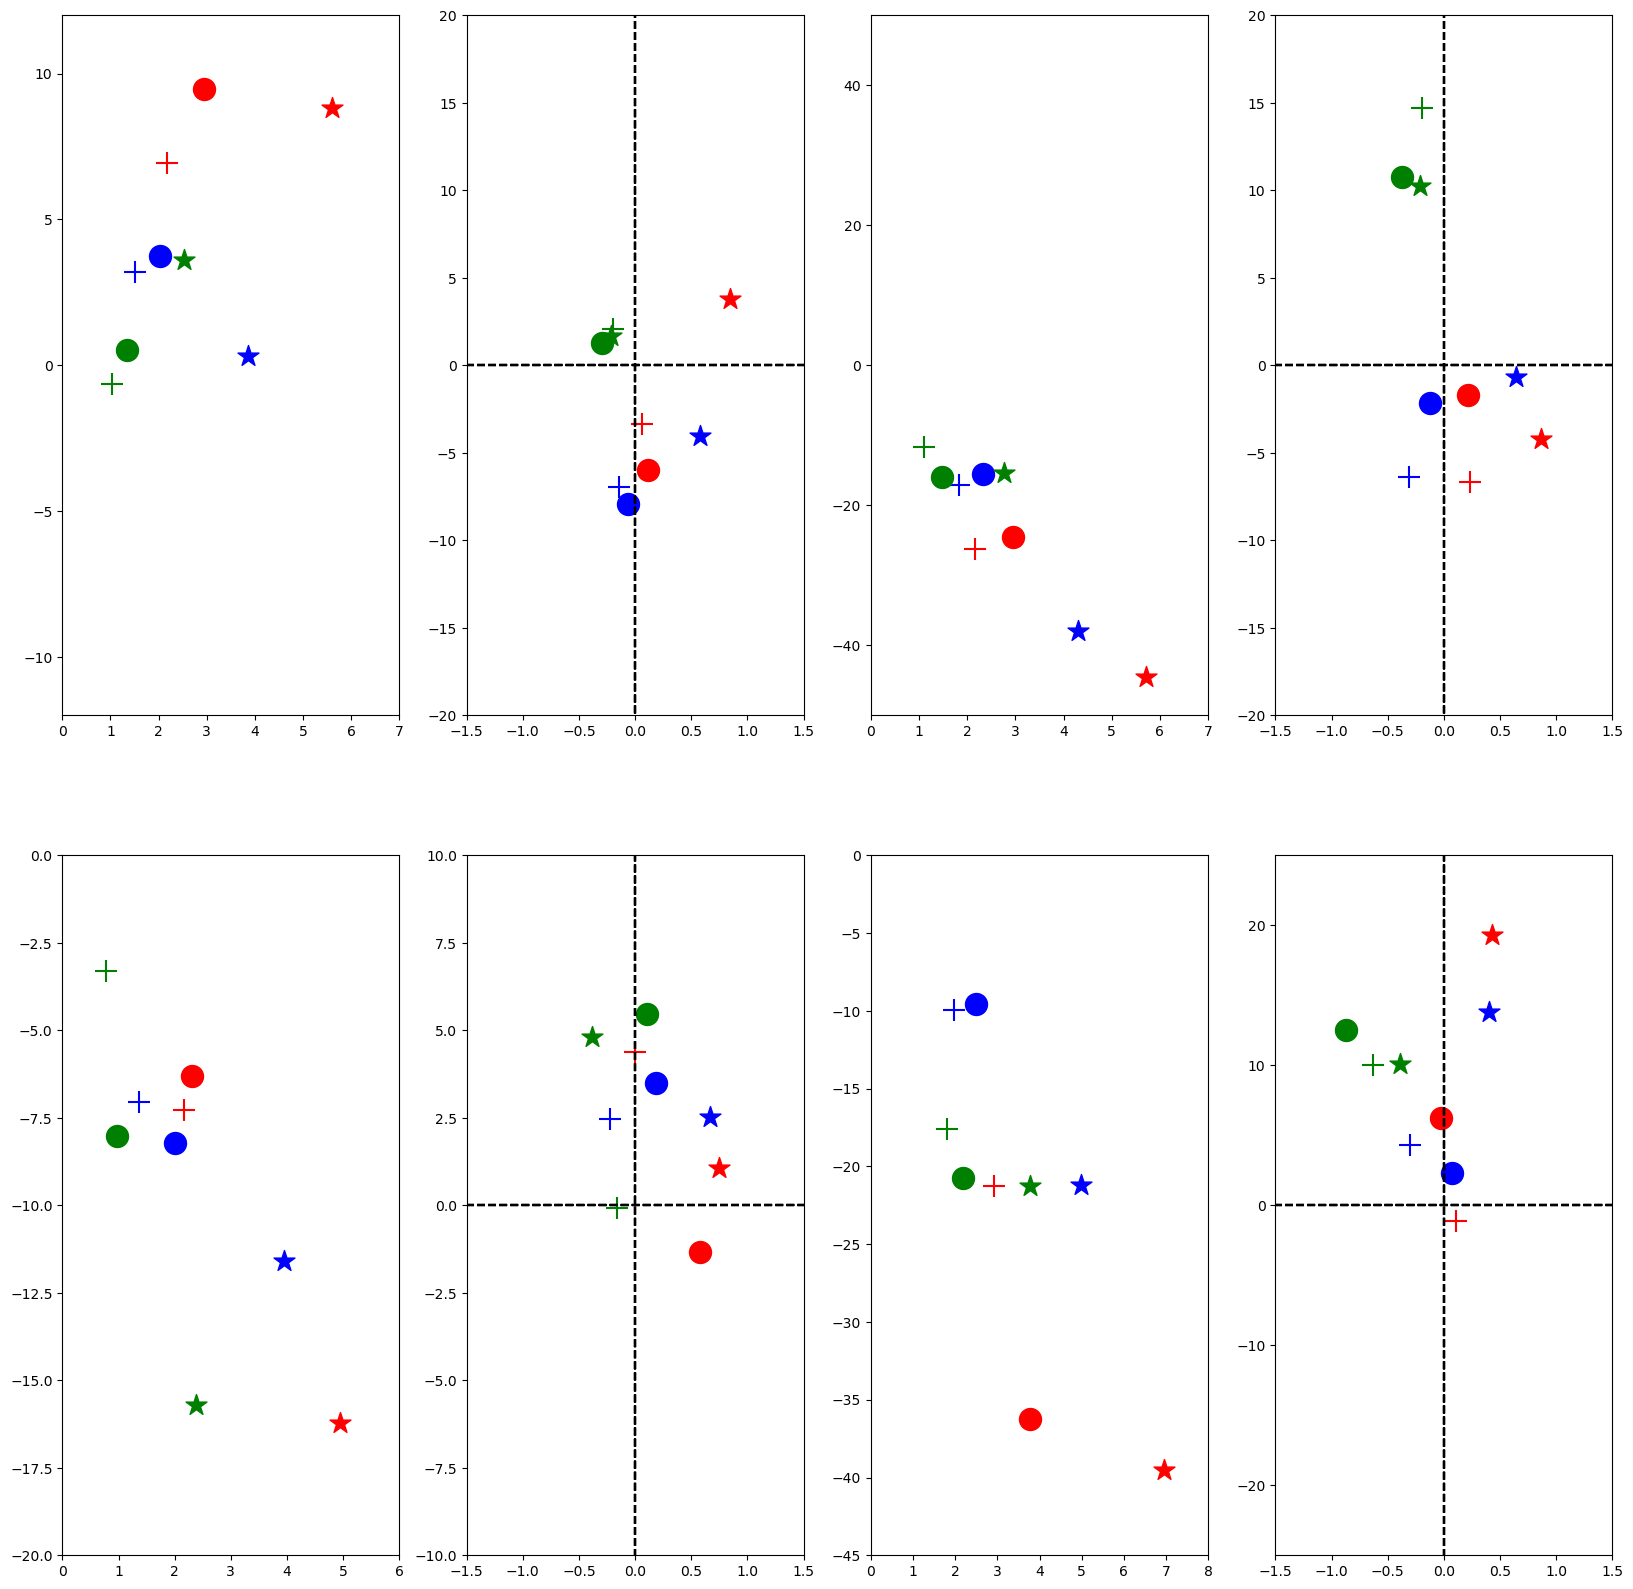

In [79]:
fig

In [80]:
# other fixes
axes[0,2].set_ylim([-50, 0])
axes[0,0].set_ylim([-5, 15])
axes[0,1].set_ylim([-10, 10])

(-10.0, 10.0)

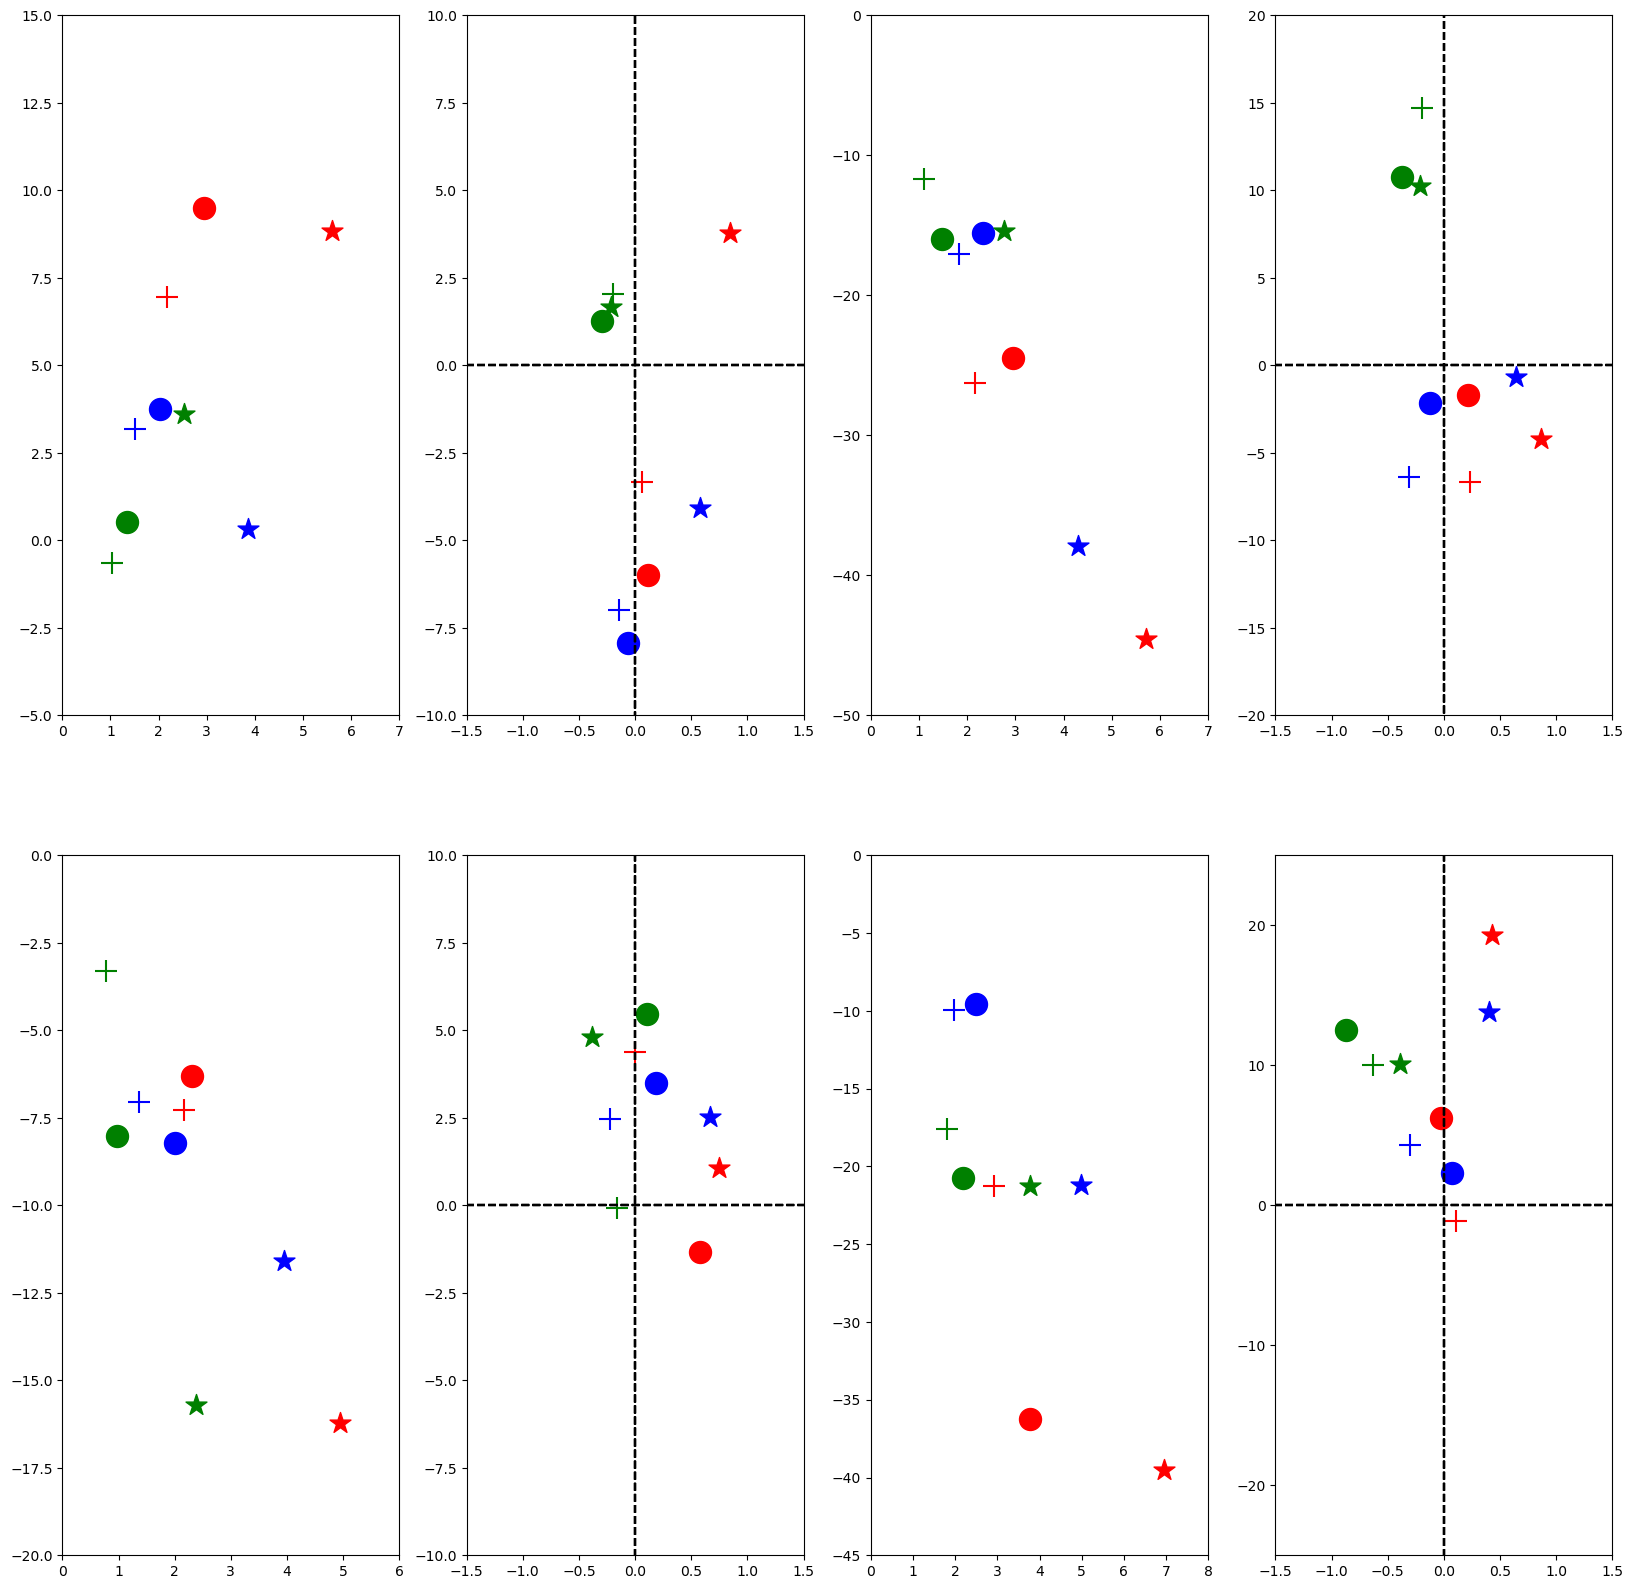

In [81]:
fig

In [82]:
axes[0,0].tick_params(axis='both', labelsize='x-large')
axes[0,1].tick_params(axis='both', labelsize='x-large')
axes[0,2].tick_params(axis='both', labelsize='x-large')
axes[0,3].tick_params(axis='both', labelsize='x-large')
axes[1,0].tick_params(axis='both', labelsize='x-large')
axes[1,1].tick_params(axis='both', labelsize='x-large')
axes[1,2].tick_params(axis='both', labelsize='x-large')
axes[1,3].tick_params(axis='both', labelsize='x-large')

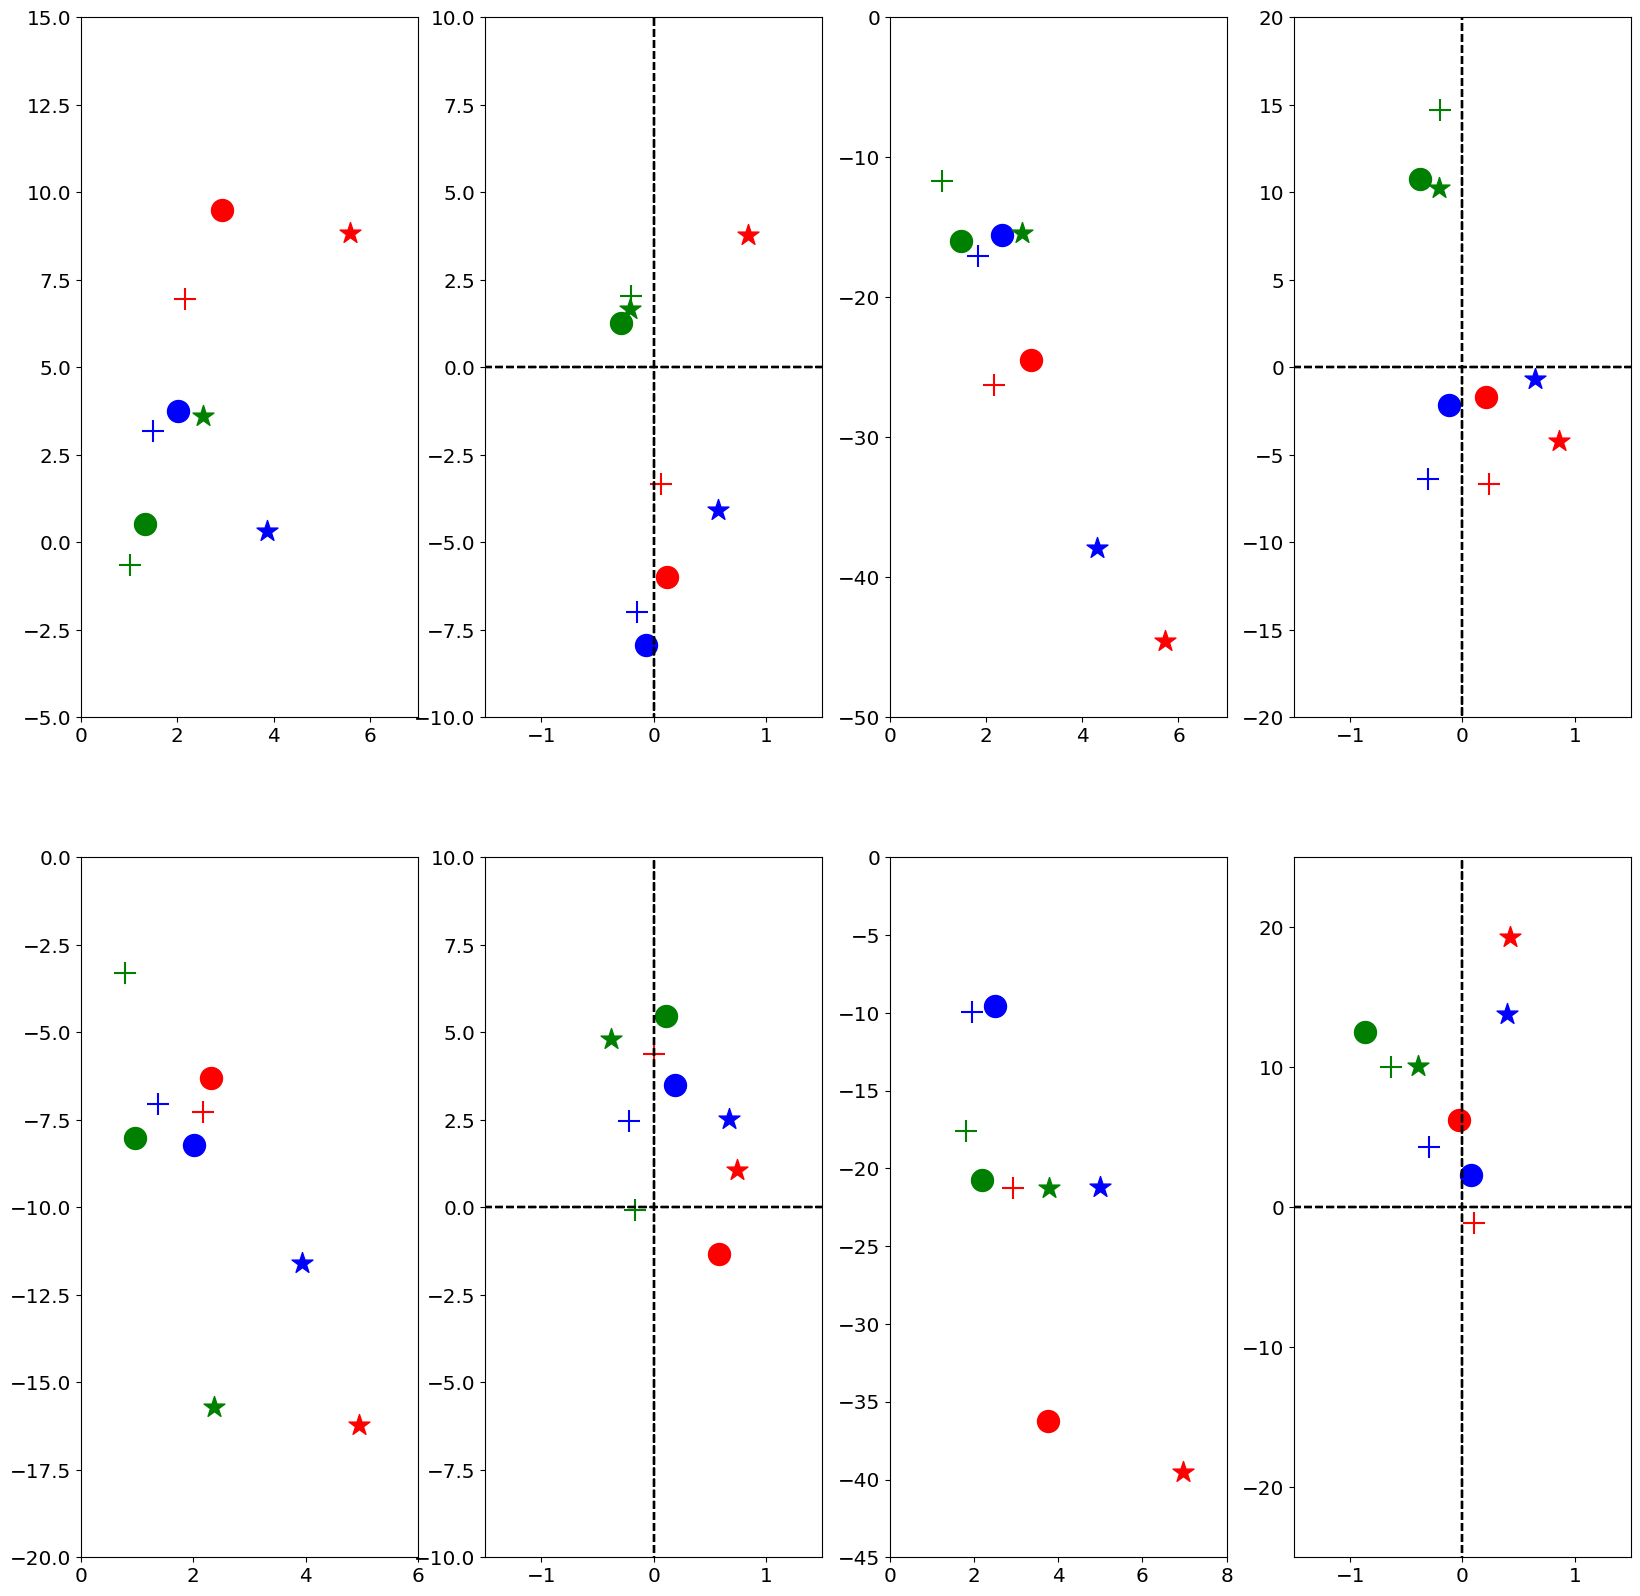

In [83]:
fig